In [1]:
library("plotgardener")
library("data.table")
library("org.Hs.eg.db")
library("TxDb.Hsapiens.UCSC.hg38.knownGene")
library(png)
options(bedtools.path = "~/anaconda3/bin/")
library(bedtoolsr)

## In this notebook, code for making genomic regions plots showing CHiC interactions and ATAC-seq signal tracks 
## Mostly using the PlotGardener package: https://phanstiellab.github.io/plotgardener/


Attaching package: ‘plotgardener’


The following object is masked from ‘package:base’:

    c


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'cit

In [2]:
loops <- fread("~/HRJ_monocytes/CHiC/chicago/combinations_output/DpnII/combined_34reps_DpnII_binsize1500_maxL150K_mergeWeights/data/combined_34reps_DpnII_binsize1500_maxL150K_mergeWeights.bedpe")
# intersect loops with proxies so we can restrict loops to just incldue them

proxies1 <- fread("~/HRJ_monocytes/findmotifs/find_new_dpnII/snps_went_into_loopingQTL_analysis.DpnII.marked.REFALTseqs.PURGED.DISTAL.txt")
proxies1[, chrom := paste0("chr", Chr)]
proxies1[, hg38Proxy_pos0 := hg38Proxy_pos-1]
proxies_small <- proxies1[, .(chrom, hg38Proxy_pos0, hg38Proxy_pos, hg38Proxy_ID, hg38SNP_ID)]
setkey(loops, V1, V2, V3)
loops1 <- foverlaps(proxies_small, loops, by.x = c("chrom", "hg38Proxy_pos0", "hg38Proxy_pos"), nomatch = NULL)
setnames(loops1, c("chrom", "V2", "V3", "V4", "V5", "V6"), c("chrom1", "start1", "end1", "chrom2", "start2", "end2"))
setkey(loops, V4, V5, V6)
loops2 <- foverlaps(proxies_small, loops, by.x = c("chrom", "hg38Proxy_pos0", "hg38Proxy_pos"), nomatch = NULL)
setnames(loops2, c("chrom", "V1", "V2", "V3", "V5", "V6"), c("chrom2", "chrom1", "start1", "end1", "start2", "end2"))
loops2_edit <- loops2[, .(chrom1, start1, end1, chrom2, start2, end2, hg38Proxy_pos0, hg38Proxy_pos, hg38Proxy_ID, hg38SNP_ID)]
loops_proxies <- rbind(loops1, loops2_edit)

## OR: we can instead look at eQTLs and only their interactions with eGenes
eqtl_inters <- fread("~/HRJ_monocytes/CHiC/chicago/findings/consensus_DpnII_level_proxy_eGene_interactions_DpnIIFilt_withGeneTypes.txt")
sig_eqtl_inters <- eqtl_inters[score >= 5]
sig_eqtl_inters <- sig_eqtl_inters[, c("Chr", "Proxy_dpnStart", "Proxy_dpnEnd", "DpnID", "Gene", "hg19SNP_ID", "hg19Proxy_ID", "hg38SNP_ID")]
# have to get other end coordinates
dpnII <- fread("~/spivakov/live/Design/Human_eQTL_CHiC_DpnII_hg38/hg38_dpnII.rmap")
setkey(dpnII, V4)
sig_eqtl_inters_dpn <- sig_eqtl_inters[dpnII, on = c(DpnID = "V4"), nomatch = NULL]
setnames(sig_eqtl_inters_dpn, c("V2", "V3"), c("TSS_dpnStart", "TSS_dpnEnd"))
sig_eqtl_inters_dpn[, chrom1 := paste0("chr", Chr)]
sig_eqtl_inters_dpn[, chrom2 := paste0("chr", V1)]
eQTL_eGene_score5 <- sig_eqtl_inters_dpn[, .(chrom1, Proxy_dpnStart, Proxy_dpnEnd, chrom2, TSS_dpnStart, TSS_dpnEnd, Gene, hg19SNP_ID, hg19Proxy_ID, hg38SNP_ID)]


# need to make proxy_sets only the ones that we keep!
proxy_sets <- fread("~/HRJ_monocytes/Browser_tracks/proxy_setshg38.bed")
eqtls <- fread("~/HRJ_monocytes/Browser_tracks/eqtlshg38.bed")
#proxies <- fread("~/HRJ_monocytes/Browser_tracks/proxieshg38.bed")
proxies <- fread("~/HRJ_monocytes/findmotifs/find_new_dpnII/snps_went_into_loopingQTL_analysis.DpnII.marked.REFALTseqs.PURGED.DISTAL.txt")
proxies[, chrom := paste0("chr", Chr)]
proxies_plot <- proxies[, .(chrom, hg38Proxy_pos, hg38Proxy_end, hg38SNP_ID)]

# Load in DpnII baits
baits <- fread("~/spivakov/live/Design/Human_eQTL_CHiC_DpnII_hg38/eCHiC_grch38.baitmap")
baits[, chrom := paste0("chr", V1)]
baits <- baits[, .(chrom, V2, V3, V4, V5)]
names(baits) = c("chrom", "DpnStart", "DpnEnd", "DpnID", "DpnName")

# also make an overlap with genes
proxies1[, TSS1 := TSS - 500]
proxies1[, TSS2 := TSS + 500]
genes_small <- proxies1[, .(chrom, TSS1, TSS2, rep_Gene, Gene, ENSG_ID)]
setkey(loops, V1, V2, V3)
loopsG1 <- foverlaps(genes_small, loops, by.x = c("chrom", "TSS1", "TSS2"), nomatch = NULL)
setnames(loopsG1, c("chrom", "V2", "V3", "V4", "V5", "V6"), c("chrom1", "start1", "end1", "chrom2", "start2", "end2"))
setkey(loops, V4, V5, V6)
loopsG2 <- foverlaps(genes_small, loops, by.x = c("chrom", "TSS1", "TSS2"), nomatch = NULL)
setnames(loopsG2, c("chrom", "V1", "V2", "V3", "V5", "V6"), c("chrom2", "chrom1", "start1", "end1", "start2", "end2"))
loopsG2_edit <- loopsG2[, .(chrom1, start1, end1, chrom2, start2, end2, TSS1, TSS2, rep_Gene, Gene, ENSG_ID)]
loops_genes <- rbind(loopsG1, loopsG2_edit)

## bring in the regions that were tested in BaseQTL. for each proxy SNP, we can filter this file and merge the gene end to make one PE contact.
regions <- fread("~/HRJ_monocytes/AS_CHiC/BaseQTL/scripts/bedpe_for_chic_egenes_with_Gene_number.txt")
regions[, chrom1 := paste0("chr", V1)]
regions[, chrom2 := paste0("chr", V4)]

In [3]:
### Read in the BaseQTL results, in order to plot the contact QTLs

BaseRes <- fread("~/HRJ_monocytes/BaseQTL/findings_round2_dpnIICorrection/BaseQTL_CHiC_Filt_on_Dpn_Distal_Rhat_AI_rsids.txt")
BaseBed <- BaseRes[Signif.99 == "yes", .(chrom, hg38Proxy_pos, hg38Proxy_end, Gene, hg19SNP_ID, BaseQTL_SNP_hg19, rsid, log_mean_aFC)]


In [4]:
### Bring in information on ATAC, H3K27ac and H3K4me1
# ATAC, prior to filtering for nearest ATAC peak within 5kb
atac <- fread("~/HRJ_monocytes/BaseQTL/findings_round2_dpnIICorrection/AT_CHiC_with_LD_SNPs_and_MikBetas_Signif99.txt")
# also for 27ac and me1
histones <- fread("~/HRJ_monocytes/BaseQTL/findings_round2_dpnIICorrection/blueprint_table_27ac_me1_sig99_LD.txt")

# make bed files for the plots. keep the name of the baseQTL ID in each case and whether the direction goes up or down.
atac[, Chr := tstrsplit(BaseQTL_SNP_hg19, split = ":", keep = 1)]
atac[, chrom := paste0("chr", Chr)]
atac_plot <- unique(atac[!is.na(at_featStart), .(chrom, at_featStart, at_featEnd, BaseQTL_SNP_hg19, chic_log_mean_aFC, at_log_mean_aFC)])

histones[, c("h3k27ac_start", "h3k27ac_end") := tstrsplit(h3k27ac_phenotypeID, split = ":", keep = c(2,3), type.convert = T)]
histones[, c("h3k4me1_start", "h3k4me1_end") := tstrsplit(h3k4me1_phenotypeID, split = ":", keep = c(2,3), type.convert = T)]
histones[, chrom := paste0("chr", Chr)]

h3k27ac <- unique(histones[!is.na(h3k27ac_phenotypeID), .(chrom, h3k27ac_start, h3k27ac_end, BaseQTL_hg19Proxy_ID, chic_log_mean_aFC, h3k27ac_beta)])
h3k4me1 <- unique(histones[!is.na(h3k4me1_phenotypeID), .(chrom, h3k4me1_start, h3k4me1_end, BaseQTL_hg19Proxy_ID, chic_log_mean_aFC, h3k4me1_beta)])

#h3k27ac
#h3k4me1

## will have to take note of the beta direction and then make unique each time

# below: THBS1 locus showing alleleic fold change
# Now trying with the consensus ATAC-seq data: pileups from 34 reps in Genrich.

In [6]:
## THBS1 locus showing alleleic fold change

pdf(file = "~/HRJ_monocytes/paper/thbs1_plotGardener_aFC_arches_V02.pdf")

### set parameters
myeQTL <- "15:39312634:C:T"
BaseSNP <- "15:39606026:C:T"
log2aFC <- 0.6
myGene = "THBS1"
mychrom = "chr15"
mystart = 39286285
myend = 39615829
###
### restrict loops to my eQTL - eGene combo
#loops_eqtl <- eQTL_eGene_score5[hg38SNP_ID == myeQTL]
# look at all loops!
loops_eqtl <- copy(loops)

### restrict eQTLs to the ones we are intersted in?
myeqtls <- eqtls[V4 %like% myeQTL]
### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]


### restrict called regions to that in BaseQTL
regions_keep <- regions[V7 %like% myGene & V7 %like% BaseSNP] # check which proxy!
regions_keep_LHS <- regions_keep[, .(chrom1, V2, V3)]
regions_keep_RHS <- regions_keep[, .(chrom2, V5, V6)]
regions_keep_all <- cbind(regions_keep_LHS, regions_keep_RHS)

# merge regions if right nect to each other! 
regions_keep_RHS_Sort <- setorder(regions_keep_RHS, cols = "V5")
regions_keep_LHS_merge <- regions_keep_LHS[1:2, ]
#LHS_merge <- bedtoolsr::bt.merge(regions_keep_LHS, d = 1)
RHS_merge <- bedtoolsr::bt.merge(regions_keep_RHS_Sort, d = 1)
setnames(RHS_merge, "V1", "chrom2")
both_regions <- cbind(regions_keep_LHS_merge, RHS_merge)
#both_regions

###
aFC <- round(2^log2aFC, digits = 2)
###

pageCreate(width = 12, height = 10, default.units = "cm", showGuides = F)

########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.3, width = 10, just = c("right", "top"), default.units = "cm")
##########

## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 2.5, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 2.8, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 6.7)


### NEW: Get plotBaits for the eGene
plotbaits <- fread("~/HRJ_monocytes/CHiC/chicago/findings/bedgraphs/THBS1_DpnII_2070430.bg")
setnames(plotbaits, "N", "score")
plotBaitsPlot <- plotSignal(
    data = plotbaits, binSize = 50, binCap = F, 
    params = params_main, height = 1, y = 5.5,
    linecolor = "#e69F00", fill = "#e69F00"
)
annoYaxis(plotBaitsPlot, at = NULL, label = T, main = TRUE, axisLine = T, params = params_main, y = 5.5, height = 0.5, fontsize = 7, fontcolor = "#37a7db")
## text for loops
plotText(label = "THBS1 CHi-C \nsignal, N reads", fontsize = 7, fontcolor = "#e69F00", rot = 0, params = params_text, y = 5.7, height = 0.5
)

###

### plot pairs and make the height equal to the score
## REF
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 3.7, height = 1, archHeight = 1, linecolor = "#0072B2", fill = "#56B4E9", flip = T, style = "3D")
}

## ALT
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 3.7, height = (1*aFC), archHeight = (1*aFC), linecolor = "#b2182b", fill = "#D55E00", flip = T, style = "3D")
}
# Text to say the fold change
plotText(label = "REF: 1", x = 2.5, y = 4, height = 0.3, fontsize = 7, fontcolor = "#0072B2", rot = 0, params=params_text)
plotText(label = paste0("ALT: ~", aFC), x = 2.5, y = 4.6, height = 0.3, fontsize = 7, fontcolor = "#b2182b", rot = 0, params=params_text)
plotText(label = "Allelic \nfold change", x = 1.3, y = 4, height = 0.3, fontcolor = "gray40", fontsize = 7, rot = 0, params=params_text)

# Plot eQTLs
plotRanges( 
    data = myeqtls, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 1.2, height = 0.3
)
# text for eQTLs
plotText(
    label = "Lead eQTL", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 1.2, height = 0.5,
)

### Plot the contact QTLs
contact <- BaseBed[Gene == myGene]
plotRanges( 
    data = contact, params = params_main, linecolor="tomato3", fill = "tomato3", collapse = T,
    y = 1.7, height = 0.3
)
# text for contact QTLs
plotText(
    label = "Contact eQTLs", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 1.8, height = 0.5,
)

# Plot proxies
plotRanges( 
    data = myproxies, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 2.2, height = 0.3
)
# text for proxies
plotText(
    label = "LD variants", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2.3, height = 0.5
)

## Add baits as a highlight
#plotRanges( 
#    data = baits[DpnName %like% myeQTL], params = params_main, fill = "gray", collapse = T, y = 0, height = 6.7, alpha = 0.4
#)


## plot ATAC - now using the proper 34 reps consensus data
ATACPval <- paste0("~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus_34reps/consensus_34reps_Pval_", mychrom, ".bw")
PvalRegion <- readBigwig(file = ATACPval,
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATACPvalPlot <- plotSignal(
    data = PvalRegion,
    params = params_main, height = 1, y = 0,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0, params = params_text, y = 0.2, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATACPvalPlot,
    at = c(0,68), label = T, # top pileup value
    main = TRUE, axisLine = T, params = params_main, y = 0, height = 1, fontsize = 7, fontcolor = "maroon3"
)


dev.off()

genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

signal[signal1]

yaxis[yaxis1]

text[text2]

arches[arches1]

arches[arches2]

arches[arches3]

arches[arches4]

text[text2]

text[text2]

text[text2]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

text[text2]

signal[signal2]

text[text2]

yaxis[yaxis2]



png 
  2

# Below: THBS1, showing local H3K27ac and the ATAC peak that is affected. 


In [7]:
# THBS1, showing local histone and ATAC peaks that are affected. 
pdf(file = "~/HRJ_monocytes/paper/thbs1_plotGardener_crossPhenotypes_V04.pdf")

### set parameters
myeQTL <- "15:39312634:C:T"
BaseSNP1 <- "15:39598843:A:G"
BaseSNP2 <- "15:39602380:A:G"
BaseSNP3 <- "15:39606026:C:T"
BaseSNP4 <- "15:39606089:A:T"
BaseSNP5 <- "15:39607442:A:G"
BaseSNP6 <- "15:39607630:A:G"
BaseSNP7 <- "15:39607665:A:G"
log2aFC <- 0.6
myGene = "THBS1"
mychrom = "chr15"
mystart = 39286285
myend = 39615829
###


### prepare ATAC peaks: now trying with pileups
myATAC <- unique(atac_plot[BaseQTL_SNP_hg19 == BaseSNP1 | BaseQTL_SNP_hg19 == BaseSNP2 |
                           BaseQTL_SNP_hg19 == BaseSNP3 | BaseQTL_SNP_hg19 == BaseSNP4 |
                           BaseQTL_SNP_hg19 == BaseSNP5 | BaseQTL_SNP_hg19 == BaseSNP6 |
                           BaseQTL_SNP_hg19 == BaseSNP7])
#myATAC[at_log_mean_aFC < 0] # none
atacUP <- unique(myATAC[, .(chrom, at_featStart, at_featEnd)])

### prepare h3k27ac peaks
myH3K27 <- unique(h3k27ac[BaseQTL_hg19Proxy_ID == BaseSNP1 | BaseQTL_hg19Proxy_ID == BaseSNP2 |
                           BaseQTL_hg19Proxy_ID == BaseSNP3 | BaseQTL_hg19Proxy_ID == BaseSNP4 |
                           BaseQTL_hg19Proxy_ID == BaseSNP5 | BaseQTL_hg19Proxy_ID == BaseSNP6 |
                           BaseQTL_hg19Proxy_ID == BaseSNP7])
#myH3K27[h3k27ac_beta < 0] # none
h3k27acUPhg19 <- unique(myH3K27[, .(chrom, h3k27ac_start, h3k27ac_end)])
# convert to hg38
h3k27acUP <- data.table(chrom = "chr15", h3k27ac_start = 39312773, 
                        h3k27ac_end = 39314688)

### prepare h3k4me1 peaks
myH3K4 <- unique(h3k4me1[BaseQTL_hg19Proxy_ID == BaseSNP1 | BaseQTL_hg19Proxy_ID == BaseSNP2 |
                           BaseQTL_hg19Proxy_ID == BaseSNP3 | BaseQTL_hg19Proxy_ID == BaseSNP4 |
                           BaseQTL_hg19Proxy_ID == BaseSNP5 | BaseQTL_hg19Proxy_ID == BaseSNP6 |
                           BaseQTL_hg19Proxy_ID == BaseSNP7])
#myH3K4[h3k4me1_beta < 0] 
h3k4me1UPhg19 <- unique(myH3K4[h3k4me1_beta > 0, .(chrom, h3k4me1_start, h3k4me1_end)])
h3k4me1DOhg19 <- unique(myH3K4[h3k4me1_beta < 0, .(chrom, h3k4me1_start, h3k4me1_end)])

# convert to hg38
h3k4me1UPhg19
h3k4me1DOhg19

h3k4me1UP <- data.table(chrom = c("chr15", "chr15", "chr15"), start = c(39308933, 39322312, 39356023), 
                        end = c(39319220, 39341364, 39360621)) 
h3k4me1DO <- data.table(chrom = c("chr15", "chr15", "chr15", "chr15", "chr15"), 
                        start = c(39171392, 39179856, 39247489, 39260104, 39193877), 
                        end = c(39174570, 39185226, 39254960, 39271107, 39198040))

### restrict loops to my eQTL - eGene combo
#loops_eqtl <- eQTL_eGene_score5[hg38SNP_ID == myeQTL]
# look at all loops!
loops_eqtl <- copy(loops)

### restrict eQTLs to the ones we are intersted in?
myeqtls <- eqtls[V4 %like% myeQTL]
### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]


### restrict called regions to that in BaseQTL
regions_keep <- regions[V7 %like% myGene & V7 %like% BaseSNP3] # check which proxy!
regions_keep_LHS <- regions_keep[, .(chrom1, V2, V3)]
regions_keep_RHS <- regions_keep[, .(chrom2, V5, V6)]
regions_keep_all <- cbind(regions_keep_LHS, regions_keep_RHS)

# merge regions if right nect to each other! 
regions_keep_RHS_Sort <- setorder(regions_keep_RHS, cols = "V5")
regions_keep_LHS_merge <- regions_keep_LHS[1:2, ]
#LHS_merge <- bedtoolsr::bt.merge(regions_keep_LHS, d = 1)
RHS_merge <- bedtoolsr::bt.merge(regions_keep_RHS_Sort, d = 1)
setnames(RHS_merge, "V1", "chrom2")
both_regions <- cbind(regions_keep_LHS_merge, RHS_merge)
#both_regions

###
aFC <- round(2^log2aFC, digits = 2)
###

pageCreate(width = 12, height = 11, default.units = "cm", showGuides = F)


## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 3.8, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 4, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 6.8)

### plot affected atac peak(s)
plotRanges( 
    data = atacUP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 2.6, height = 0.3
)
# text for ATAC
plotText(
    label = "Affected ATAC", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 2.7, height = 0.5,
)

### plot affected h3k27ac peaks
plotRanges( 
    data = h3k27acUP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 3, height = 0.3
)
# text for H3K27ac
plotText(
    label = "Affected H3K27ac", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3.1, height = 0.5,
)
# h3k4me1 can go at 2.2
plotRanges( 
    data = h3k4me1UP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 3.4, height = 0.3
)
# text 
plotText(
    label = "Affected H3K4me1", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3.5, height = 0.5,
)
# There is no h3k4me1 down
#plotRanges( 
#    data = h3k4me1DO, params = params_main, linecolor="fill", fill = "blue", collapse = T,
#    y = 3.2, height = 0.3
#)
# text
#plotText(
#    label = "Affected H3K4me1 DOWN", 
#    fontsize = 7, fontcolor = "blue", rot = 0, params = params_text, y = 3.2, height = 0.5,
#)


###

### plot pairs and make the height equal to the score
## REF
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 5, height = 1, archHeight = 1, linecolor = "#0072B2", fill = "#56B4E9", flip = T, style = "3D")
}

## ALT
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 5, height = (1*aFC), archHeight = (1*aFC), linecolor = "#b2182b", fill = "#D55E00", flip = T, style = "3D")
}
# Text to say the fold change
plotText(label = "REF: 1", x = 2.5, y = 5.3, height = 0.3, fontsize = 7, fontcolor = "#0072B2", rot = 0, params=params_text)
plotText(label = paste0("ALT: ~", aFC), x = 2.5, y = 6, height = 0.3, fontsize = 7, fontcolor = "#b2182b", rot = 0, params=params_text)
plotText(label = "CHi-C allelic \nfold change", x = 1.3, y = 5.3, height = 0.3, fontcolor = "gray40", fontsize = 7, rot = 0, params=params_text)


### Plot the contact QTLs
contact <- BaseBed[Gene == myGene]
plotRanges( 
    data = contact, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 2.2, height = 0.3
)
# text for contact QTLs
plotText(
    label = "Contact eQTLs", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2.2, height = 0.5,
)




# The below pileups look good.

ATAC_REF_Pileup <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/merge_genos/THBS1/REF_Genrich_merged_THBS1_locus_Pileup.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)

ATAC_ALT_Pileup <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/merge_genos/THBS1/ALT_Genrich_merged_THBS1_locus_Pileup.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)

# scale ALT and REF.
totalREF <- sum(ATAC_REF_Pileup$score)
totalALT <- sum(ATAC_ALT_Pileup$score)
totalREF
totalALT
ratio <- totalALT/totalREF
ratio
ATAC_REF_Pileup$score <- ATAC_REF_Pileup$score*ratio

top_alt <- max(ATAC_ALT_Pileup$score)
# then height of REF = max(ALT)
# and scale accordingly
ATAC_REF_Pileupplot <- plotSignal(
    data = ATAC_REF_Pileup,
    params = params_main, height = 1, y = 0,
    linecolor = "#0072B2", range=c(0,2000)
)

ATAC_ALT_Pileupplot <- plotSignal(
    data = ATAC_ALT_Pileup,
    params = params_main, height = 1, y = 1,
    linecolor = "#b2182b", range=c(0,2000)
)
# plot points at 1000 intervals
plotSegments(x0=c(2,2), y0=c(0.5, 1.5), x1=12, y1=c(0.5, 1.5), 
             params = params_main, linecolor = c("gray80", "gray80")
)

plotText(
    label = "ATAC-seq, REF\n(scaled pileups)", fontsize = 7, fontcolor = "#0072B2",
    rot = 0, params = params_text, y = 0.4, height = 0.5
) 

plotText(
    label = "ATAC-seq, ALT\n(scaled pileups)", fontsize = 7, fontcolor = "#b2182b",
    rot = 0, params = params_text, y = 1.4, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATAC_REF_Pileupplot,
    at = NULL, label = T, # top pileup value
    main = TRUE, axisLine = T, params = params_main, y = 0, height = 1, fontsize = 7, fontcolor = "maroon3"
)
annoYaxis(
    ATAC_ALT_Pileupplot,
    at = NULL, label = T, # top pileup value
    main = TRUE, axisLine = T, params = params_main, y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)

dev.off()

chrom,h3k4me1_start,h3k4me1_end
<chr>,<int>,<int>
chr15,39601134,39611421
chr15,39614513,39633565
chr15,39648224,39652822


chrom,h3k4me1_start,h3k4me1_end
<chr>,<int>,<int>
chr15,39463593,39466771
chr15,39472057,39477427
chr15,39539690,39547161
chr15,39552305,39563308
chr15,39486078,39490241


genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

text[text2]

arches[arches1]

arches[arches2]

arches[arches3]

arches[arches4]

text[text2]

text[text2]

text[text2]

ranges[ranges4]

text[text2]



[1] 29551183

[1] 21663557

[1] 0.7330859

signal[signal1]

signal[signal2]

segments[segments1]

text[text2]

text[text2]

yaxis[yaxis1]

yaxis[yaxis2]



png 
  2

In [20]:
### chekc the change in ATAC signal.
atacUP
ATAC_REF_Pileup_dt <- as.data.table(ATAC_REF_Pileup)
region_ref <- ATAC_REF_Pileup_dt[start >= 39312360 & end <= 39318460, c("seqnames", "score")]
ref <- region_ref[, lapply(.SD, mean), by="seqnames"]
ref # 68.09358

ATAC_ALT_Pileup_dt <- as.data.table(ATAC_ALT_Pileup)
region_alt <- ATAC_ALT_Pileup_dt[start >= 39312360 & end <= 39318460, c("seqnames", "score")]
alt <- region_alt[, lapply(.SD, mean), by="seqnames"]
alt # 149.4578

alt$score/ref$score



chrom,at_featStart,at_featEnd
<chr>,<int>,<int>
chr15,39312360,39318460


seqnames,score
<fct>,<dbl>
chr15,68.09358


seqnames,score
<fct>,<dbl>
chr15,149.4578


[1] 2.194889

In [13]:
## plot ATAC: Pileups

ATACPileup <- paste0("~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus_34reps/consensus_34reps_Pileup_", mychrom, ".bw")
PileupRegion <- readBigwig(file = ATACPileup,
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATACPileupPlot <- plotSignal(
    data = PileupRegion,
    params = params_main, height = 1, y = 0,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(Read pileup)", fontsize = 7, fontcolor = "seagreen",
    rot = 0, params = params_text, y = 0.2, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATACPileupPlot,
    at = NULL, label = T, # top pileup value
    main = TRUE, axisLine = T, params = params_main, y = 0, height = 1, fontsize = 7, fontcolor = "maroon3"
)

# Height of this difRegion should be around 0.4
difRegion <- readBigwig(file = ATACPileup,
                        chrom = mychrom,
                        chromstart = atacUP$at_featStart,
                        chromend = atacUP$at_featEnd)

ATACdifRegionALT <- plotSignal(
    data = difRegion,
    params = params_main, height = 0.4, y = 0.6,
    linecolor = "#b2182b", 
    fill = "#b2182b"
)

chrom,at_featStart,at_featEnd
<chr>,<int>,<int>
chr15,39312360,39318460


In [21]:
## TFPT and OSCAR locus showing alleleic fold change, flipped arches

pdf(file = "~/HRJ_monocytes/paper/TFPT_plotGardener_aFC_arches_flipped.pdf")

### set parameters
myeQTL <- "19:54045772:T:C"
BaseSNP <- "19:54551115:G:T"
log2aFC1 <- -0.6040825
log2aFC2 <- -0.3432409
myGene1 = "TFPT"
myGene2 = "OSCAR"
mychrom = "chr19"
mystart = 54036654
myend = 54131092 

###

### restrict loops to my eQTL - eGene combo
loops_eqtl <- eQTL_eGene_score5[hg38SNP_ID == myeQTL]
### restrict eQTLs to the ones we are intersted in?
myeqtls <- eqtls[V4 %like% myeQTL]
### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]

### restrict called regions to that in BaseQTL
regions_keep <- regions[V7 %like% myGene1 & V7 %like% BaseSNP] # check which proxy!
regions_keep_LHS <- regions_keep[, .(chrom1, V2, V3)]
regions_keep_RHS <- regions_keep[, .(chrom2, V5, V6)]
regions_keep_all1 <- cbind(regions_keep_LHS, regions_keep_RHS)
# using regions_keep_all; only one promoter tested
regions_keep <- regions[V7 %like% myGene2 & V7 %like% BaseSNP] # check which proxy!
regions_keep_LHS <- regions_keep[, .(chrom1, V2, V3)]
regions_keep_RHS <- regions_keep[, .(chrom2, V5, V6)]
regions_keep_all2 <- cbind(regions_keep_LHS, regions_keep_RHS)
# merge regions if right nect to each other! 
#regions_keep_RHS_Sort <- setorder(regions_keep_RHS, cols = "V5")
#regions_keep_LHS_merge <- regions_keep_LHS[1:2, ]
#LHS_merge <- bedtoolsr::bt.merge(regions_keep_LHS, d = 1)
#RHS_merge <- bedtoolsr::bt.merge(regions_keep_RHS_Sort, d = 1)
#setnames(RHS_merge, "V1", "chrom2")
#both_regions <- cbind(regions_keep_LHS_merge, RHS_merge)
#both_regions

###
aFC1 <- round(2^log2aFC1, digits = 2)
aFC2 <- round(2^log2aFC2, digits = 2)

###

pageCreate(width = 12, height = 10, default.units = "cm", showGuides = F)

########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.3, width = 10, just = c("right", "top"), default.units = "cm")
##########

## specify the gene target
geneHighlights <- data.frame("geneName" = c(myGene1, myGene2), "color" = "chartreuse4")


## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 4, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 4.3, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 7.3)


### NEW: Get plotBaits for the eGene
plotbaits <- fread("~/HRJ_monocytes/CHiC/chicago/findings/bedgraphs/TFPT_DpnII_3013211.bg")
setnames(plotbaits, "N", "score")
plotBaitsPlot <- plotSignal(
    data = plotbaits, binSize = 50, binCap = F, 
    params = params_main, height = 1, y = 6.2,
    linecolor = "#e69F00", fill = "#e69F00"
)
annoYaxis(plotBaitsPlot, at = NULL, label = T, main = TRUE, axisLine = T, params = params_main, y = 6.2, height = 0.5, fontsize = 7, fontcolor = "#37a7db")
### text for loops
plotText(label = "TFPT CHi-C \nsignal, N reads", fontsize = 7, fontcolor = "#e69F00", rot = 0, params = params_text, y = 6.3, height = 0.5
)

###

########### TFPT
### plot pairs and make the height equal to the score

## REF
for(n in 1:nrow(regions_keep_all1)) {
    myplot <- plotPairsArches(data = regions_keep_all1[n, ], params = params_main, y = 0.8, height = 1, archHeight = 1, linecolor = "#0072B2", fill = "#56B4E9", flip = F, style = "3D", 
                             baseline = T)
}
## ALT
for(n in 1:nrow(regions_keep_all1)) {
    plotPairsArches(data = regions_keep_all1[n, ], params = params_main, y = 1.8-aFC1, height = (1*aFC1), archHeight = (1*aFC), linecolor = "#b2182b", fill = "#D55E00", flip = F, style = "3D", 
                   baseline = T)
}
# range for REF - test
annoYaxis(
    myplot,
    at = NULL, label = T, 
    main = TRUE, axisLine = T, params = params_main, y = 3.7, height = 1, fontsize = 7, fontcolor = "maroon3"
)

# Text to say the fold change
plotText(label = "REF: 1", x = 3.1, y = 0.8, height = 0.3, fontsize = 7, fontcolor = "#0072B2", rot = 0, params=params_text)
plotText(label = paste0("ALT: ", aFC1), x = 3.1, y = 1.2, height = 0.3, fontsize = 7, fontcolor = "#b2182b", rot = 0, params=params_text)
plotText(label = "Allelic fold \nchange (CI 0.99)", x = 1.3, y = 0.9, height = 0.3, fontsize = 7, rot = 0, params=params_text)
#plotSegments(x0 = 2, x1 = 12, y0 = 4.7, y1 = 4.7, linecolor = "grey", lwd = 0.5, params = params_main)


######### OSCAR
for(n in 1:nrow(regions_keep_all2)) {
    myplot2 <- plotPairsArches(data = regions_keep_all2[n, ], params = params_main, y = 2, height = 1, archHeight = 1, linecolor = "#0072B2", fill = "#56B4E9", flip = F, style = "3D", alpha = 0.15, 
                              baseline = T)
}
## ALT
for(n in 1:nrow(regions_keep_all2)) {
    plotPairsArches(data = regions_keep_all2[n, ], params = params_main, y = 3-aFC1, height = (1*aFC1), archHeight = (1*aFC1), linecolor = "#b2182b", fill = "#D55E00", flip = F, style = "3D", alpha = 0.15, 
                   baseline = T)
}
## REF
# range for REF - test
annoYaxis(
    myplot2,
    at = NULL, label = T, 
    main = TRUE, axisLine = T, params = params_main, y = 5, height = 1, fontsize = 7, fontcolor = "maroon3"
)
#plotSegments(x0 = 2, x1 = 12, y0 = 6, y1 = 6, linecolor = "grey", lwd = 0.5, params = params_main)

# Text to say the fold change
plotText(label = "REF: 1", x = 3, y = 2.2, height = 0.3, fontsize = 7, fontcolor = "#0072B2", rot = 0, params=params_text)
plotText(label = paste0("ALT: ", aFC2), x = 3.1, y = 2.6, height = 0.3, fontsize = 7, fontcolor = "#b2182b", rot = 0, params=params_text)
plotText(label = "Allelic fold \nchange (CI 0.90)", x = 1.3, y = 2.2, height = 0.3, fontsize = 7, rot = 0, params=params_text)



# Plot eQTLs
plotRanges( 
    data = myeqtls, params = params_main, linecolor="tomato3", fill = "tomato3", collapse = T,
    y = 3.2, height = 0.3
)
# text for eQTLs
plotText(
    label = "Lead eQTL", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3.2, height = 0.5,
)

# Plot proxies
plotRanges( 
    data = myproxies, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 3.7, height = 0.3
)
# text for proxies
plotText(
    label = "LD SNPs", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 3.7, height = 0.5
)

## Add baits as a highlight
#plotRanges( 
#    data = baits[DpnName %like% myeQTL], params = params_main, fill = "gray", collapse = T, y = 0, height = 8, alpha = 0.4
#)


## plot ATAC
atac_myregion <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 5,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0, params = params_text, y = 5, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0, 12), label = c(0, 12), # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 5, height = 1, fontsize = 7, fontcolor = "maroon3"
)

dev.off()

genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

signal[signal1]

yaxis[yaxis1]

text[text2]

arches[arches1]

arches[arches2]

yaxis[yaxis2]

text[text2]

text[text2]

text[text2]

arches[arches3]

arches[arches4]

yaxis[yaxis3]

text[text2]

text[text2]

text[text2]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

signal[signal2]

text[text2]

yaxis[yaxis4]



png 
  2

In [22]:
# TFPT and OSCAR locus showing alleleic fold change, regular arches

pdf(file = "~/HRJ_monocytes/paper/TFPT_plotGardener_aFC_arches_V02.pdf")

### set parameters
myeQTL <- "19:54045772:T:C"
BaseSNP <- "19:54551115:G:T"
log2aFC1 <- -0.6040825
log2aFC2 <- -0.3432409
myGene1 = "TFPT"
myGene2 = "OSCAR"
mychrom = "chr19"
mystart = 54036654
myend = 54131092 

###

### restrict loops to my eQTL - eGene combo
loops_eqtl <- eQTL_eGene_score5[hg38SNP_ID == myeQTL]
### restrict eQTLs to the ones we are intersted in?
myeqtls <- eqtls[V4 %like% myeQTL]
### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]

### restrict called regions to that in BaseQTL
regions_keep <- regions[V7 %like% myGene1 & V7 %like% BaseSNP] # check which proxy!
regions_keep_LHS <- regions_keep[, .(chrom1, V2, V3)]
regions_keep_RHS <- regions_keep[, .(chrom2, V5, V6)]
regions_keep_all1 <- cbind(regions_keep_LHS, regions_keep_RHS)
# using regions_keep_all; only one promoter tested
regions_keep <- regions[V7 %like% myGene2 & V7 %like% BaseSNP] # check which proxy!
regions_keep_LHS <- regions_keep[, .(chrom1, V2, V3)]
regions_keep_RHS <- regions_keep[, .(chrom2, V5, V6)]
regions_keep_all2 <- cbind(regions_keep_LHS, regions_keep_RHS)
# merge regions if right nect to each other! 
#regions_keep_RHS_Sort <- setorder(regions_keep_RHS, cols = "V5")
#regions_keep_LHS_merge <- regions_keep_LHS[1:2, ]
#LHS_merge <- bedtoolsr::bt.merge(regions_keep_LHS, d = 1)
#RHS_merge <- bedtoolsr::bt.merge(regions_keep_RHS_Sort, d = 1)
#setnames(RHS_merge, "V1", "chrom2")
#both_regions <- cbind(regions_keep_LHS_merge, RHS_merge)
#both_regions

###
aFC1 <- round(2^log2aFC1, digits = 2)
aFC2 <- round(2^log2aFC2, digits = 2)

###

pageCreate(width = 12, height = 10, default.units = "cm", showGuides = F)

########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.3, width = 10, just = c("right", "top"), default.units = "cm")
##########

## specify the gene target
geneHighlights <- data.frame("geneName" = c(myGene1, myGene2), "color" = "chartreuse4")


## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 3, height = 1)

# text for genes
plotText(
    label = "Genes", fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 3.3, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 7.6)


### NEW: Get plotBaits for the eGene
plotbaits <- fread("~/HRJ_monocytes/CHiC/chicago/findings/bedgraphs/TFPT_DpnII_3013211.bg")
setnames(plotbaits, "N", "score")
plotBaitsPlot <- plotSignal(data = plotbaits, binSize = 50, binCap = F, 
    params = params_main, height = 1, y = 6.3,linecolor = "#e69F00", fill = "#e69F00"
)

annoYaxis(plotBaitsPlot, at = NULL, label = T, main = TRUE, axisLine = T, params = params_main, y = 6.3, height = 0.5, fontsize = 7, fontcolor = "#37a7db")
### text for loops
plotText(label = "TFPT CHi-C \nsignal, N reads", fontsize = 7, fontcolor = "#e69F00", rot = 0, params = params_text, y = 6.6, height = 0.5
)

########### TFPT
### plot pairs and make the height equal to the score

## REF
for(n in 1:nrow(regions_keep_all1)) {
    myplot <- plotPairsArches(data = regions_keep_all1[n, ], params = params_main, y = 4.1, height = 1, archHeight = 1, linecolor = "#0072B2", fill = "#56B4E9", flip = T, style = "3D", 
                             baseline = F)
}
## ALT
for(n in 1:nrow(regions_keep_all1)) {
    plotPairsArches(data = regions_keep_all1[n, ], params = params_main, y = 4.1, height = (1*aFC1), archHeight = (1*aFC1), linecolor = "#b2182b", fill = "#D55E00", flip = T, style = "3D", 
                   baseline = F)
}

# Text to say the fold change
plotText(label = "REF: 1", x = 3.1, y = 4.2, height = 0.3, fontsize = 7, fontcolor = "#0072B2", rot = 0, params=params_text)
plotText(label = paste0("ALT: ", aFC1), x = 3.1, y = 4.7, height = 0.3, fontsize = 7, fontcolor = "#b2182b", rot = 0, params=params_text)
plotText(label = "Allelic \nfold change", x = 1.3, fontcolor = "gray40", y = 4.3, height = 0.3, fontsize = 7, rot = 0, params=params_text)
#plotSegments(x0 = 2, x1 = 12, y0 = 4.7, y1 = 4.7, linecolor = "grey", lwd = 0.5, params = params_main)

######### OSCAR
for(n in 1:nrow(regions_keep_all2)) {
    myplot2 <- plotPairsArches(data = regions_keep_all2[n, ], params = params_main, y = 5.2, height = 1, archHeight = 1, linecolor = "#0072B2", fill = "#56B4E9", flip = T, style = "3D", alpha = 0.15, 
                              baseline = F)
}
## ALT
for(n in 1:nrow(regions_keep_all2)) {
    plotPairsArches(data = regions_keep_all2[n, ], params = params_main, y = 5.2, height = (1*aFC1), archHeight = (1*aFC1), linecolor = "#b2182b", fill = "#D55E00", flip = T, style = "3D", alpha = 0.15, 
                   baseline = F)
}

#plotSegments(x0 = 2, x1 = 12, y0 = 6, y1 = 6, linecolor = "grey", lwd = 0.5, params = params_main)

# Text to say the fold change
plotText(label = "REF: 1", x = 3, y = 5.3, height = 0.3, fontsize = 7, fontcolor = "#0072B2", rot = 0, params=params_text)
plotText(label = paste0("ALT: ", aFC2), x = 3.1, y = 5.7, height = 0.3, fontsize = 7, fontcolor = "#b2182b", rot = 0, params=params_text)
plotText(label = "Allelic fold \nchange (NS)", x = 1.3, fontcolor = "gray40", y = 5.3, height = 0.3, fontsize = 7, rot = 0, params=params_text)

# Plot eQTLs
plotRanges( 
    data = myeqtls, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 1.7, height = 0.3
)
# text for eQTLs
plotText(
    label = "Lead eQTL", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 1.8, height = 0.5,
)

### Plot the contact QTL, TFPT - would it be the same SNP? Yes, would be the same one
contact <- BaseBed[Gene == myGene1]
plotRanges( 
    data = contact, params = params_main, linecolor="tomato3", fill = "tomato3", collapse = T,
    y = 2.2, height = 0.3
)
# text for contact QTLs
plotText(
    label = "Contact eQTL", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 2.3, height = 0.5,
)

# Plot proxies
plotRanges( 
    data = myproxies, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 2.7, height = 0.3
)
# text for proxies
plotText(
    label = "LD variants", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2.8, height = 0.5
)

## plot ATAC
## plot ATAC - now using the proper 34 reps consensus data
ATACPval <- paste0("~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus_34reps/consensus_34reps_Pval_", mychrom, ".bw")
PvalRegion <- readBigwig(file = ATACPval,
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATACPvalPlot <- plotSignal(
    data = PvalRegion,
    params = params_main, height = 1, y = 0.5,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0, params = params_text, y = 0.8, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATACPvalPlot,
    at = c(0,60), label = T, # top P value
    main = TRUE, axisLine = T, params = params_main, y = 0.5, height = 1, fontsize = 7, fontcolor = "maroon3"
)
dev.off()
#regions_keep_all1
#regions_keep_all2

genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

signal[signal1]

yaxis[yaxis1]

text[text2]

arches[arches1]

arches[arches2]

text[text2]

text[text2]

text[text2]

arches[arches3]

arches[arches4]

text[text2]

text[text2]

text[text2]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

text[text2]

signal[signal2]

text[text2]

yaxis[yaxis2]



png 
  2

genes[genes1]

text[text1]

genomeLabel[genomeLabel1]

signal[signal1]

yaxis[yaxis1]

text[text2]

arches[arches1]

arches[arches2]

arches[arches3]

arches[arches4]

text[text2]

text[text2]

text[text2]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

text[text2]

signal[signal2]

text[text2]

yaxis[yaxis2]

text[text2]

text[text2]

yaxis[yaxis3]

yaxis[yaxis4]



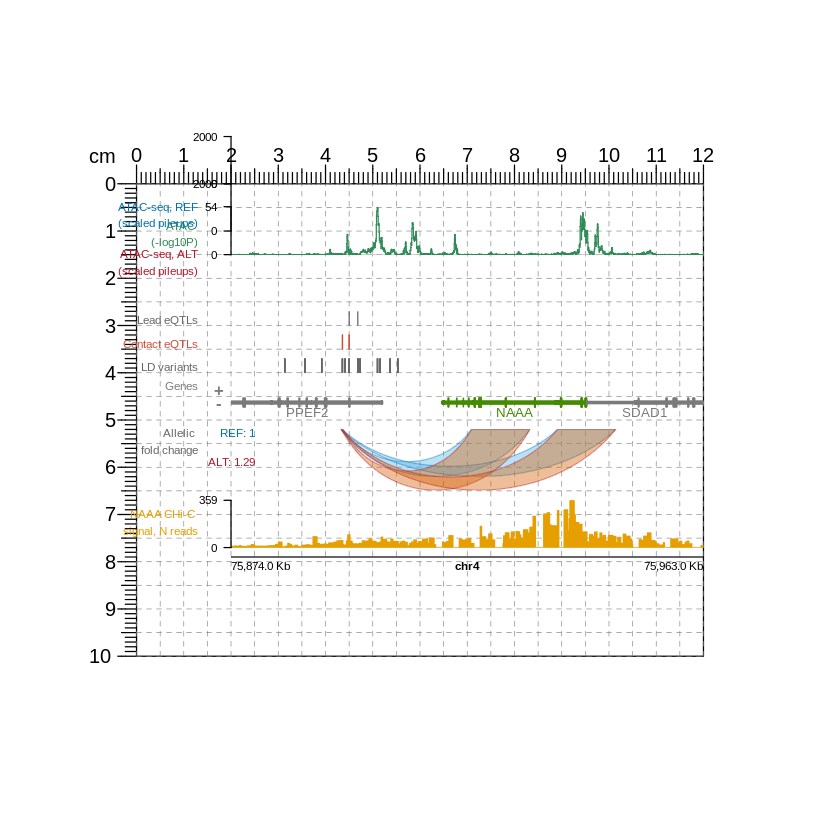

In [23]:
### NAAA locus, different genotypes

#pdf(file = "~/HRJ_monocytes/paper/NAAA_plotGardener_aFC_V02.pdf")

### set parameters
myeQTL1 <- "4:75897880:A:G"
myeQTL2 <- "4:75896259:G:A"
BaseSNP= "4:76816143:G:A"
log2aFC <- 0.3708849
myGene = "NAAA"
mychrom = "chr4"
mystart = 75874000
myend = 75963000
###
### restrict loops to my eQTL
loops_eqtl <- loops_proxies[hg38SNP_ID == myeQTL1 | hg38SNP_ID == myeQTL2]
### restrict eQTLs to the ones we are interested in
myeqtls <- eqtls[V4 %like% myeQTL1 | V4 %like% myeQTL2]
### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL1 | hg38SNP_ID == myeQTL2]

### restrict called regions to that in BaseQTL
regions_keep <- regions[V7 %like% myGene & V7 %like% BaseSNP] # check which proxy!
regions_keep_LHS <- regions_keep[, .(chrom1, V2, V3)]
regions_keep_RHS <- regions_keep[, .(chrom2, V5, V6)]
regions_keep_all <- cbind(regions_keep_LHS, regions_keep_RHS)

# merge regions if right nect to each other! 
regions_keep_RHS_Sort <- setorder(regions_keep_RHS, cols = "V5")
regions_keep_LHS_merge <- regions_keep_LHS[1:2, ]
#LHS_merge <- bedtoolsr::bt.merge(regions_keep_LHS, d = 1)
RHS_merge <- bedtoolsr::bt.merge(regions_keep_RHS_Sort, d = 1)
setnames(RHS_merge, "V1", "chrom2")
both_regions <- cbind(regions_keep_LHS_merge, RHS_merge)
#both_regions

###
aFC <- round(2^log2aFC, digits = 2)
###

pageCreate(width = 12, height = 10, default.units = "cm", showGuides = T)

########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.3, width = 10, just = c("right", "top"), default.units = "cm")
##########

## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 4, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 4.2, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Kb", fontsize = 7, y = 7.9)


### NEW: Get plotBaits for the eGene
plotbaits <- fread("~/HRJ_monocytes/CHiC/chicago/findings/bedgraphs/NAAA_DpnII_4605248.bg")
setnames(plotbaits, "N", "score")
plotBaitsPlot <- plotSignal(
    data = plotbaits, binSize = 50, binCap = F, 
    params = params_main, height = 1, y = 6.7,
    linecolor = "#e69F00", fill = "#e69F00"
)
annoYaxis(plotBaitsPlot, at = NULL, label = T, main = TRUE, axisLine = T, params = params_main, y = 6.7, height = 0.5, fontsize = 7, fontcolor = "#37a7db")
## text for loops
plotText(label = "NAAA CHi-C \nsignal, N reads", fontsize = 7, fontcolor = "#e69F00", rot = 0, params = params_text, y = 6.9, height = 0.5
)

###

### plot pairs and make the height equal to the score
### HERE for NAAA using the "both_regions" object where I have merged the frags on the right that were adjacent.
## REF
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 5.2, height = 1, archHeight = 1, linecolor = "#0072B2", fill = "#56B4E9", flip = T)
}

## ALT
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 5.2, height = (1*aFC), archHeight = (1*aFC), linecolor = "#b2182b", fill = "#D55E00", flip = T)
}
# Text to say the fold change
plotText(label = "REF: 1", x = 2.5, y = 5.2, height = 0.3, fontsize = 7, fontcolor = "#0072B2", rot = 0, params=params_text)
plotText(label = paste0("ALT: ", aFC), x = 2.5, y = 5.8, height = 0.3, fontsize = 7, fontcolor = "#b2182b", rot = 0, params=params_text)
plotText(label = "Allelic \nfold change", x = 1.3, y = 5.2, height = 0.3, fontsize = 7, fontcolor = "gray40", rot = 0, params=params_text)

# Plot eQTLs
plotRanges( 
    data = myeqtls, params = params_main, linecolor="gray40", fill = "gray40", collapse = T,
    y = 2.7, height = 0.3
)
# text for eQTLs
plotText(
    label = "Lead eQTLs", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2.8, height = 0.5,
)

### Plot the contact QTL, TFPT - would it be the same SNP? Yes, would be the same one
contact <- BaseBed[Gene == myGene]
plotRanges( 
    data = contact, params = params_main, linecolor="tomato3", fill = "tomato3", collapse = T,
    y = 3.2, height = 0.3
)
# text for contact QTLs
plotText(
    label = "Contact eQTLs", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3.3, height = 0.5,
)

# Plot proxies
plotRanges( 
    data = myproxies, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 3.7, height = 0.3
)
# text for proxies
plotText(
    label = "LD variants", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 3.8, height = 0.5
)

## Add baits as a highlight
#plotRanges( 
#    data = baits[DpnName %like% myeQTL1 | DpnName %like% myeQTL2], params = params_main, fill = "gray", collapse = T, y = 0, height = 6.7, alpha = 0.4
#)


## plot ATAC
## plot ATAC - now using the proper 34 reps consensus data
ATACPval <- paste0("~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus_34reps/consensus_34reps_Pval_", mychrom, ".bw")
PvalRegion <- readBigwig(file = ATACPval,
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATACPvalPlot <- plotSignal(
    data = PvalRegion,
    params = params_main, height = 1, y = 0.5,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0, params = params_text, y = 0.8, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATACPvalPlot,
    at = c(0,54), label = T, # top P value
    main = TRUE, axisLine = T, params = params_main, y = 0.5, height = 1, fontsize = 7, fontcolor = "maroon3"
)

plotText(
    label = "ATAC-seq, REF\n(scaled pileups)", fontsize = 7, fontcolor = "#0072B2",
    rot = 0, params = params_text, y = 0.4, height = 0.5
) 

plotText(
    label = "ATAC-seq, ALT\n(scaled pileups)", fontsize = 7, fontcolor = "#b2182b",
    rot = 0, params = params_text, y = 1.4, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATAC_REF_Pileupplot,
    at = NULL, label = T, # top pileup value
    main = TRUE, axisLine = T, params = params_main, y = 0, height = 1, fontsize = 7, fontcolor = "maroon3"
)
annoYaxis(
    ATAC_ALT_Pileupplot,
    at = NULL, label = T, # top pileup value
    main = TRUE, axisLine = T, params = params_main, y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)

#dev.off()

In [24]:
# NAAA, showing local methylation and the ATAC peak that is affected. For the SNP 4:76817412:G:A
pdf(file = "~/HRJ_monocytes/paper/NAAA_plotGardener_crossPhenotypes_V04.pdf")

### THIS ONE HAS THE CORRECT CODE FOR ATAC

### set parameters
myeQTL1 <- "4:75897880:A:G" #Note our proxy is associated with both eQTLs
myeQTL2 <- "4:75896259:G:A"
BaseSNP= "4:76817412:G:A"
log2aFC <- 0.2695567
myGene = "NAAA"
mychrom = "chr4"
mystart = 75884000
myend = 75973000
###

###
aFC <- round(2^log2aFC, digits = 2)
###

### restrict loops to my eQTL
loops_eqtl <- loops_proxies[hg38SNP_ID == myeQTL1 | hg38SNP_ID == myeQTL2]
### restrict eQTLs to the ones we are interested in
myeqtls <- eqtls[V4 %like% myeQTL1 | V4 %like% myeQTL2]
### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL1 | hg38SNP_ID == myeQTL2]
myproxies_mycontactQTL <- myproxies[hg38Proxy_pos == 75896259]

### restrict called regions to that in BaseQTL
regions_keep <- regions[V7 %like% myGene & V7 %like% BaseSNP] # check which proxy!
regions_keep_LHS <- regions_keep[, .(chrom1, V2, V3)]
regions_keep_RHS <- regions_keep[, .(chrom2, V5, V6)]
regions_keep_all <- cbind(regions_keep_LHS, regions_keep_RHS)

# merge regions if right nect to each other! 
regions_keep_RHS_Sort <- setorder(regions_keep_RHS, cols = "V5")
regions_keep_LHS_merge <- regions_keep_LHS[1:2, ]
#LHS_merge <- bedtoolsr::bt.merge(regions_keep_LHS, d = 1)
RHS_merge <- bedtoolsr::bt.merge(regions_keep_RHS_Sort, d = 1)
setnames(RHS_merge, "V1", "chrom2")
both_regions <- cbind(regions_keep_LHS_merge, RHS_merge)
#both_regions

### Get the ATAC peak that is affected.
#mypeakStart <- 75899810
#mypeakEnd <- 75902380
#log2aFC_at <- 0.3901208
### 
### prepare ATAC peaks
myATAC <- unique(atac_plot[BaseQTL_SNP_hg19 == BaseSNP])
#myATAC[at_log_mean_aFC < 0] # none
atacUP <- unique(myATAC[, .(chrom, at_featStart, at_featEnd)])

### Get the methylation peak that is affected - NOT PLOTTING NOW
methStart <- 75902508
methEnd <- 75902509
###

### prepare h3k27ac peaks
myH3K27 <- unique(h3k27ac[BaseQTL_hg19Proxy_ID == BaseSNP])
#myH3K27[h3k27ac_beta < 0] # none
h3k27acUPhg19 <- unique(myH3K27[, .(chrom, h3k27ac_start, h3k27ac_end)])
# convert to hg38
h3k27acUP <- data.table(chrom = c("chr4", "chr4", "chr4"), 
                        h3k27ac_start = c(75900658, 75912570, 75932155), 
                        h3k27ac_end = c(75910105, 75932117, 75954921))
 #                       h3k27ac_end = 39314688)

### prepare h3k4me1 peaks
myH3K4 <- unique(h3k4me1[BaseQTL_hg19Proxy_ID == BaseSNP])
#myH3K4[h3k4me1_beta < 0] # none
#myH3K4[h3k4me1_beta > 0] 

h3k4me1UPhg19 <- unique(myH3K4[h3k4me1_beta > 0, .(chrom, h3k4me1_start, h3k4me1_end)])
#h3k4me1DOhg19 <- unique(myH3K4[h3k4me1_beta < 0, .(chrom, h3k4me1_start, h3k4me1_end)])

# convert to hg38
h3k4me1UP <- data.table(chrom = c("chr4", "chr4"), start = c(75898590, 75914051), 
                        end = c(75913068, 75916835)) 


##############################################

pageCreate(width = 12, height = 8, default.units = "cm", showGuides = F)

##############################################
########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.3, width = 10, just = c("right", "top"), default.units = "cm")
##############################################

## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")



## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 3.8, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 4, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 6.8)

### plot affected atac peak(s)
plotRanges( 
    data = atacUP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 2.6, height = 0.3
)
# text for ATAC
plotText(
    label = "Affected ATAC", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 2.7, height = 0.5,
)

### plot affected h3k27ac peaks
plotRanges( 
    data = h3k27acUP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 3, height = 0.3
)
# text for H3K27ac
plotText(
    label = "Affected H3K27ac", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3.1, height = 0.5,
)
# h3k4me1 can go at 2.2
plotRanges( 
    data = h3k4me1UP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 3.4, height = 0.3
)

# text 
plotText(
    label = "Affected H3K4me1", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3.5, height = 0.5,
)
# There is no h3k4me1 down
#plotRanges( 
#    data = h3k4me1DO, params = params_main, linecolor="fill", fill = "blue", collapse = T,
#    y = 3.2, height = 0.3
#)
# text
#plotText(
#    label = "Affected H3K4me1 DOWN", 
#    fontsize = 7, fontcolor = "blue", rot = 0, params = params_text, y = 3.2, height = 0.5,
#)


###

### plot pairs and make the height equal to the score
## REF
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 5, height = 1, archHeight = 1, linecolor = "#0072B2", fill = "#56B4E9", flip = T, style = "3D")
}

## ALT
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 5, height = (1*aFC), archHeight = (1*aFC), linecolor = "#b2182b", fill = "#D55E00", flip = T, style = "3D")
}
# Text to say the fold change
plotText(label = "REF: 1", x = 2.5, y = 5.3, height = 0.3, fontsize = 7, fontcolor = "#0072B2", rot = 0, params=params_text)
plotText(label = paste0("ALT: ~", aFC), x = 2.5, y = 6, height = 0.3, fontsize = 7, fontcolor = "#b2182b", rot = 0, params=params_text)
plotText(label = "CHi-C allelic \nfold change", x = 1.3, y = 5.3, height = 0.3, fontcolor = "gray40", fontsize = 7, rot = 0, params=params_text)

### Plot the contact QTLs
contact <- BaseBed[Gene == myGene]
plotRanges( 
    data = contact, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 2.2, height = 0.3
)
# text for contact QTLs
plotText(
    label = "Contact eQTLs", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2.2, height = 0.5,
)

## Add baits as a highlight
#plotRanges( 
#    data = baits[DpnName %like% myeQTL], params = params_main, fill = "gray", collapse = T, y = 0, height = 6.7, alpha = 0.4
#)


ATACREF_pileup <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/merge_genos/NAAA/REF_Genrich_merged_NAAA_locus_Pileup.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)

ATACALT_pileup <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/merge_genos/NAAA/ALT_Genrich_merged_NAAA_locus_Pileup.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)

# scale ALT and REF.
totalREF <- sum(ATACREF_pileup$score)
totalALT <- sum(ATACALT_pileup$score)
totalREF
totalALT
ratio <- totalALT/totalREF
ratio
ATACREF_pileup$score <- ATACREF_pileup$score*ratio
# then height of REF = max(ALT)
# and scale accordingly
altmax <- max(ATACALT_pileup$score)
refmax <- max(ATACREF_pileup$score)
altmax
refmax

ATACPvalPlot_REF <- plotSignal(
    data = ATACREF_pileup,
    params = params_main, height = 1, y = 0,
    linecolor = "#0072B2", range=c(0,1500) # need to try to show scale
)
ATACPvalPlot_ALT <- plotSignal(
    data = ATACALT_pileup,
    params = params_main, height = 1, y = 1,
    linecolor = "#b2182b", range=c(0,1500)
)

# plot points at 500 intervals
plotSegments(x0=c(2,2), y0=c(0.333, 0.666, 1.333, 1.666), x1=12, y1=c(0.333,0.666, 1.333, 1.666), 
             params = params_main, linecolor = c("gray80", "gray80", "gray80", "gray80")
)
             

# range for ATAC
annoYaxis(
    ATACPvalPlot_REF,
    at = NULL, label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 0, height = 1, fontsize = 7, fontcolor = "maroon3"
)
annoYaxis(
    ATACPvalPlot_ALT,
    at = NULL, label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)

plotText(
    label = "ATAC-seq, REF\n(scaled pileups)", fontsize = 7, fontcolor = "#0072B2",
    rot = 0, params = params_text, y = 0.4, height = 0.5
) 

plotText(
    label = "ATAC-seq, ALT\n(scaled pileups)", fontsize = 7, fontcolor = "#b2182b",
    rot = 0, params = params_text, y = 1.4, height = 0.5
) 

#atacUP
#REFdt <- as.data.table(ATACREF_pileup)
#REFdt_region <- REFdt[start >= 75906970 & end <= 75908720]
#ALTdt <- as.data.table(ATACALT_pileup)
#ALTdt_region <- ALTdt[start >= 75906970 & end <= 75908720]
#max(REFdt_region$score)
#max(ALTdt_region$score)
dev.off()

genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

text[text2]

arches[arches1]

arches[arches2]

arches[arches3]

arches[arches4]

text[text2]

text[text2]

text[text2]

ranges[ranges4]

text[text2]



[1] 3282670

[1] 1767716

[1] 0.5384995

[1] 1420

[1] 1079.153

signal[signal1]

signal[signal2]

segments[segments1]

yaxis[yaxis1]

yaxis[yaxis2]

text[text2]

text[text2]



png 
  2

In [31]:
### chekc the change in ATAC signal.
atacUP1 <- atacUP[1, ]
atacUP2 <- atacUP[2, ]
ATAC_REF_Pileup_dt <- as.data.table(ATACREF_pileup)
region_ref <- ATAC_REF_Pileup_dt[start >= 75899810 & end <= 75902380, c("seqnames", "score")]
ref <- region_ref[, lapply(.SD, mean), by="seqnames"]
ref # 219.9

ATAC_ALT_Pileup_dt <- as.data.table(ATACALT_pileup)
region_alt <- ATAC_ALT_Pileup_dt[start >= 75899810 & end <= 75902380, c("seqnames", "score")]
alt <- region_alt[, lapply(.SD, mean), by="seqnames"]
alt # 296.7

alt$score/ref$score



atacUP2
ATAC_REF_Pileup_dt <- as.data.table(ATACREF_pileup)
region_ref <- ATAC_REF_Pileup_dt[start >= 75906970 & end <= 75908720, c("seqnames", "score")]
ref <- region_ref[, lapply(.SD, mean), by="seqnames"]
ref # 219.9

ATAC_ALT_Pileup_dt <- as.data.table(ATACALT_pileup)
region_alt <- ATAC_ALT_Pileup_dt[start >= 75906970 & end <= 75908720, c("seqnames", "score")]
alt <- region_alt[, lapply(.SD, mean), by="seqnames"]
alt # 296.7

alt$score/ref$score




seqnames,score
<fct>,<dbl>
chr4,219.9288


seqnames,score
<fct>,<dbl>
chr4,296.7347


[1] 1.349231

chrom,at_featStart,at_featEnd
<chr>,<int>,<int>
chr4,75906970,75908720


seqnames,score
<fct>,<dbl>
chr4,147.5804


seqnames,score
<fct>,<dbl>
chr4,190.3282


[1] 1.289658

In [21]:
### SVIL locus, different genotypes and histone modification locations

pdf(file = "~/HRJ_monocytes/paper/SVIL_plotGardener_crossPhenos_V03.pdf")

### set parameters
myeQTL <- "10:29803371:C:T"
myGene = "SVIL"
BaseSNP <- "10:30092300:C:T"
mychrom = "chr10"
mystart = 29500000
myend = 29920000
log2aFC = 0.9863521
###
### restrict loops to my eQTL
loops_eqtl <- loops_proxies[hg38SNP_ID == myeQTL]
###
### restrict eQTL locus to my (distal) one
proxy_sets_thisone <- proxy_sets[V4 == myeQTL]
###
### restrict eQTLs to the ones we are interested in
myeqtls <- eqtls[V4 %like% myeQTL]
### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]
myproxies_mycontactQTL <- myproxies[hg38Proxy_pos == 29803371]

### Get the ATAC peak that is affected.
mypeakStart <- 29802946
mypeakEnd <- 29805396
### 

### Get the H3K27ac peaks that are affected
start27ac1 <- 29802175
start27ac2 <- 29811026
start27ac3 <- 29750500
end27ac1 <- 29805744
end27ac2 <- 29813167
end27ac3 <- 29752865
###


### Get the H3K4me1 peaks that are affected
startme1_1 <- 29798790
startme1_2 <- 29825092
startme1_3 <- 29847491
startme1_4 <- 29856821
endme1_1 <- 29814327
endme1_2 <- 29830969
endme1_3 <- 29852391
endme1_4 <- 29862027
###

### restrict called regions to that in BaseQTL
regions_keep <- regions[V7 %like% myGene & V7 %like% BaseSNP] # check which proxy!
regions_keep_LHS <- regions_keep[, .(chrom1, V2, V3)]
regions_keep_RHS <- regions_keep[, .(chrom2, V5, V6)]
regions_keep_all <- cbind(regions_keep_RHS, regions_keep_LHS)
both_regions <- copy(regions_keep_all)
#regions_keep_RHS_Sort <- setorder(regions_keep_RHS, cols = "V5")
#LHS_merge <- bedtoolsr::bt.merge(regions_keep_LHS, d = 1000000)
#RHS_merge <- bedtoolsr::bt.merge(regions_keep_RHS_Sort, d = 1000000)
#both_regions <- cbind(RHS_merge, LHS_merge) ### have to put them the other way rounbd for this one
###
aFC <- round(2^log2aFC, digits = 2)
###

### prepare ATAC peaks
myATAC <- unique(atac_plot[BaseQTL_SNP_hg19 == BaseSNP])
myATAC[at_log_mean_aFC < 0] # none
atacUP <- unique(myATAC[, .(chrom, at_featStart, at_featEnd)])


### prepare h3k27ac peaks
myH3K27 <- unique(h3k27ac[BaseQTL_hg19Proxy_ID == BaseSNP])
myH3K27[h3k27ac_beta < 0] # none
h3k27acUPhg19 <- unique(myH3K27[, .(chrom, h3k27ac_start, h3k27ac_end)])
# convert to hg38
h3k27acUP <- data.table(chrom = c("chr10", "chr10", "chr10"), 
                        h3k27ac_start = c(start27ac1, start27ac2, start27ac3), 
                        h3k27ac_end = c(end27ac1, end27ac2, end27ac3))

### prepare h3k4me1 peaks
myH3K4 <- unique(h3k4me1[BaseQTL_hg19Proxy_ID == BaseSNP])
#myH3K4[h3k4me1_beta < 0] # none
#myH3K4[h3k4me1_beta > 0] 

h3k4me1UPhg19 <- unique(myH3K4[h3k4me1_beta > 0, .(chrom, h3k4me1_start, h3k4me1_end)])
#h3k4me1DOhg19 <- unique(myH3K4[h3k4me1_beta < 0, .(chrom, h3k4me1_start, h3k4me1_end)])

# convert to hg38
h3k4me1UP <- data.table(chrom = c("chr10", "chr10", "chr10", "chr10"), 
                        start = c(startme1_1, startme1_2, startme1_3, startme1_4), 
                        end = c(endme1_1, endme1_2, endme1_3, endme1_4)) 


######################################


pageCreate(width = 12, height = 8, default.units = "cm", showGuides = F)

########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.5, width = 10, just = c("right", "top"), default.units = "cm")
##########

## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")



## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 3.8, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 4, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 7.2)

### plot affected atac peak(s)
plotRanges( 
    data = atacUP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 2.6, height = 0.3
)
# text for ATAC
plotText(
    label = "Affected ATAC", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 2.7, height = 0.5,
)

### plot affected h3k27ac peaks
plotRanges( 
    data = h3k27acUP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 3, height = 0.3
)
# text for H3K27ac
plotText(
    label = "Affected H3K27ac", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3.1, height = 0.5,
)
# h3k4me1 can go at 2.2
plotRanges( 
    data = h3k4me1UP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 3.4, height = 0.3
)

# text 
plotText(
    label = "Affected H3K4me1", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3.5, height = 0.5,
)
# There is no h3k4me1 down
#plotRanges( 
#    data = h3k4me1DO, params = params_main, linecolor="fill", fill = "blue", collapse = T,
#    y = 3.2, height = 0.3
#)
# text
#plotText(
#    label = "Affected H3K4me1 DOWN", 
#    fontsize = 7, fontcolor = "blue", rot = 0, params = params_text, y = 3.2, height = 0.5,
#)


###

### plot pairs and make the height equal to the score
## REF
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 5, height = 1, archHeight = 1, linecolor = "#0072B2", fill = "#56B4E9", flip = T, style = "3D")
}

## ALT
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 5, height = (1*aFC), archHeight = (1*aFC), linecolor = "#b2182b", fill = "#D55E00", flip = T, style = "3D")
}
# Text to say the fold change
plotText(label = "REF: 1", x = 2.5, y = 5.3, height = 0.3, fontsize = 7, fontcolor = "#0072B2", rot = 0, params=params_text)
plotText(label = paste0("ALT: ~", aFC), x = 2.5, y = 6, height = 0.3, fontsize = 7, fontcolor = "#b2182b", rot = 0, params=params_text)
plotText(label = "CHi-C allelic \nfold change", x = 1.3, y = 5.3, height = 0.3, fontcolor = "gray40", fontsize = 7, rot = 0, params=params_text)

### Plot the contact QTLs
contact <- BaseBed[Gene == myGene]
plotRanges( 
    data = contact, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 2.2, height = 0.3
)
# text for contact QTLs
plotText(
    label = "Contact eQTLs", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2.2, height = 0.5,
)

## Add baits as a highlight
#plotRanges( 
#    data = baits[DpnName %like% myeQTL], params = params_main, fill = "gray", collapse = T, y = 0, height = 6.7, alpha = 0.4
#)


## plot ATAC

ATACREF_pileup <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/merge_genos/SVIL/REF_Genrich_merged_SVIL_locus_Pileup.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)

ATACALT_pileup <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/merge_genos/SVIL/ALT_Genrich_merged_SVIL_locus_Pileup.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)

# scale ALT and REF.
totalREF <- sum(ATACREF_pileup$score)
totalALT <- sum(ATACALT_pileup$score)
totalREF
totalALT
ratio <- totalALT/totalREF
ratio
ATACREF_pileup$score <- ATACREF_pileup$score*ratio
# then height of REF = max(ALT)
# and scale accordingly
altmax <- max(ATACALT_pileup$score)

ATACPvalPlot_REF <- plotSignal(
    data = ATACREF_pileup,
    params = params_main, height = 1, y = 0,
    linecolor = "#0072B2", range=c(0,altmax)
)
ATACPvalPlot_ALT <- plotSignal(
    data = ATACALT_pileup,
    params = params_main, height = 1, y = 1,
    linecolor = "#b2182b"
)


# range for ATAC
annoYaxis(
    ATACPvalPlot_REF,
    at = NULL, label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 0, height = 1, fontsize = 7, fontcolor = "maroon3"
)
annoYaxis(
    ATACPvalPlot_ALT,
    at = NULL, label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)
plotText(
    label = "ATAC-seq, REF\n(scaled pileups)", fontsize = 7, fontcolor = "#0072B2",
    rot = 0, params = params_text, y = 0.4, height = 0.5
) 

plotText(
    label = "ATAC-seq, ALT\n(scaled pileups)", fontsize = 7, fontcolor = "#b2182b",
    rot = 0, params = params_text, y = 1.4, height = 0.5
) 


dev.off()

chrom,at_featStart,at_featEnd,BaseQTL_SNP_hg19,chic_log_mean_aFC,at_log_mean_aFC
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>


chrom,h3k27ac_start,h3k27ac_end,BaseQTL_hg19Proxy_ID,chic_log_mean_aFC,h3k27ac_beta
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>


genes[genes1]

text[text1]

Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

text[text2]

arches[arches1]

arches[arches2]

arches[arches3]

arches[arches4]

text[text2]

text[text2]

text[text2]

ranges[ranges4]

text[text2]



[1] 21336240

[1] 1135910

[1] 0.05323853

signal[signal1]

signal[signal2]

yaxis[yaxis1]

yaxis[yaxis2]

text[text2]

text[text2]



png 
  2

In [32]:
### KCNK13 locus, different genotypes and histone modification locations

pdf(file = "~/HRJ_monocytes/paper/KCNK13_plotGardener_crossPhenos_V03.pdf")

### set parameters
myeQTL <- "14:90106140:T:C"
myGene = "KCNK13"
BaseSNP <- "14:90560777:T:C"
mychrom = "chr14"
mystart = 90035331
myend = 90201804
log2aFC = 0.5761226
###
### restrict loops to my eQTL
loops_eqtl <- loops_proxies[hg38SNP_ID == myeQTL]
###
### restrict eQTL locus to my (distal) one
proxy_sets_thisone <- proxy_sets[V4 == myeQTL]
###

### restrict eQTLs to the ones we are intersted in?
myeqtls <- eqtls[V4 %like% myeQTL]

### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]

### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]
myproxies_mycontactQTL <- myproxies[hg38Proxy_pos == 90094433]

### prepare ATAC peaks
myATAC <- unique(atac_plot[BaseQTL_SNP_hg19 == BaseSNP])
myATAC[at_log_mean_aFC < 0] # none
atacUP <- unique(myATAC[, .(chrom, at_featStart, at_featEnd)])

### Get the H3K27ac peaks that are affected
start27ac1 <- 90059597
start27ac2 <- 90086206
start27ac3 <- 90092863
end27ac1 <- 90064335
end27ac2 <- 90089211
end27ac3 <- 90094840
###
### prepare h3k27ac peaks
myH3K27 <- unique(h3k27ac[BaseQTL_hg19Proxy_ID == BaseSNP])
#myH3K27[h3k27ac_beta < 0] # none
h3k27acUPhg19 <- unique(myH3K27[, .(chrom, h3k27ac_start, h3k27ac_end)])
# convert to hg38
h3k27acUP <- data.table(chrom = c(mychrom, mychrom, mychrom), 
                        h3k27ac_start = c(start27ac1, start27ac2, start27ac3), 
                        h3k27ac_end = c(end27ac1, end27ac2, end27ac3))

### Get the H3K4me1 peaks that are affected
startme1_1 <- 90080589
endme1_1 <- 90098669
###

### prepare h3k4me1 peaks
myH3K4 <- unique(h3k4me1[BaseQTL_hg19Proxy_ID == BaseSNP])
#myH3K4[h3k4me1_beta < 0]# none
h3k4me1UPhg19 <- unique(myH3K4[h3k4me1_beta > 0, .(chrom, h3k4me1_start, h3k4me1_end)])
myH3K4
# convert to hg38
h3k4me1UP <- data.table(chrom = mychrom, start = startme1_1, end =  endme1_1)


### restrict called regions to that in BaseQTL
regions_keep <- regions[V7 %like% myGene & V7 %like% BaseSNP] # check which proxy!
regions_keep_LHS <- regions_keep[, .(chrom1, V5, V6)] # NOTE : for this, had to swap RHS and LHS
regions_keep_RHS <- regions_keep[, .(chrom2, V2, V3)]
regions_keep_all <- cbind(regions_keep_LHS, regions_keep_RHS)
both_regions <- copy(regions_keep_all)
# merge regions if right nect to each other! 
#regions_keep_RHS_Sort <- setorder(regions_keep_RHS, cols = "V5")
#regions_keep_LHS_merge <- regions_keep_LHS[1:2, ]
##LHS_merge <- bedtoolsr::bt.merge(regions_keep_LHS, d = 1)
#RHS_merge <- bedtoolsr::bt.merge(regions_keep_RHS_Sort, d = 1)
#setnames(RHS_merge, "V1", "chrom2")
#both_regions <- cbind(regions_keep_LHS_merge, RHS_merge)
#both_regions


aFC <- round(2^log2aFC, digits = 2)
###

pageCreate(width = 12, height = 8, default.units = "cm", showGuides = F)


########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.5, width = 10, just = c("right", "top"), default.units = "cm")
##########



###
aFC <- round(2^log2aFC, digits = 2)
###



## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 3.8, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 4, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 6.3)

### plot affected atac peak(s)
plotRanges( 
    data = atacUP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 2.6, height = 0.3
)
# text for ATAC
plotText(
    label = "Affected ATAC", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 2.7, height = 0.5,
)

### plot affected h3k27ac peaks
plotRanges( 
    data = h3k27acUP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 3, height = 0.3
)
# text for H3K27ac
plotText(
    label = "Affected H3K27ac", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3.1, height = 0.5,
)
# h3k4me1 can go at 2.2
plotRanges( 
    data = h3k4me1UP, params = params_main, linecolor="fill", fill = "tomato3", collapse = T,
    y = 3.4, height = 0.3
)
# text 
plotText(
    label = "Affected H3K4me1", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 3.5, height = 0.5,
)
# There is no h3k4me1 down
#plotRanges( 
#    data = h3k4me1DO, params = params_main, linecolor="fill", fill = "blue", collapse = T,
#    y = 3.2, height = 0.3
#)
# text
#plotText(
#    label = "Affected H3K4me1 DOWN", 
#    fontsize = 7, fontcolor = "blue", rot = 0, params = params_text, y = 3.2, height = 0.5,
#)


###

### plot pairs and make the height equal to the score
## REF
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 4.5, height = 1, archHeight = 1, linecolor = "#0072B2", fill = "#56B4E9", flip = T)
}

## ALT
for(n in 1:nrow(both_regions)) {
    plotPairsArches(data = both_regions[n, ], params = params_main, y = 4.5, height = (1*aFC), archHeight = (1*aFC), linecolor = "#b2182b", fill = "#D55E00", flip = T)
}
# Text to say the fold change
plotText(label = "REF: 1", x = 2.5, y = 4.8, height = 0.3, fontsize = 7, fontcolor = "#0072B2", rot = 0, params=params_text)
plotText(label = paste0("ALT: ~", aFC), x = 2.5, y = 5.5, height = 0.3, fontsize = 7, fontcolor = "#b2182b", rot = 0, params=params_text)
plotText(label = "CHi-C allelic \nfold change", x = 1.3, y = 4.8, height = 0.3, fontcolor = "gray40", fontsize = 7, rot = 0, params=params_text)


### Plot the contact QTLs
contact <- BaseBed[Gene == myGene]
plotRanges( 
    data = contact, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 2.2, height = 0.3
)
# text for contact QTLs
plotText(
    label = "Contact eQTLs", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2.2, height = 0.5,
)

## Add baits as a highlight
#plotRanges( 
#    data = baits[DpnName %like% myeQTL], params = params_main, fill = "gray", collapse = T, y = 0, height = 6.7, alpha = 0.4
#)


## plot ATAC


ATACREF_pileup <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/merge_genos/KCNK13/REF_Genrich_merged_KCNK13_locus_Pileup.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)

ATACALT_pileup <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/merge_genos/KCNK13/ALT_Genrich_merged_KCNK13_locus_Pileup.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
# scale ALT and REF.
totalREF <- sum(ATACREF_pileup$score)
totalALT <- sum(ATACALT_pileup$score)
totalREF
totalALT
ratio <- totalALT/totalREF
ratio
ATACREF_pileup$score <- ATACREF_pileup$score*ratio
# then height of REF = max(ALT)
# and scale accordingly
altmax <- max(ATACALT_pileup$score)

ATACPvalPlot_REF <- plotSignal(
    data = ATACREF_pileup,
    params = params_main, height = 1, y = 0,
    linecolor = "#0072B2", range=c(0,3000) # instead of altmax
)
ATACPvalPlot_ALT <- plotSignal(
    data = ATACALT_pileup,
    params = params_main, height = 1, y = 1,
    linecolor = "#b2182b", range=c(0,3000)
)

# plot points at 500 intervals
plotSegments(x0=c(2,2), y0=c(0.333, 0.666, 1.333, 1.666), x1=12, y1=c(0.333,0.666, 1.333, 1.666), 
             params = params_main, linecolor = c("gray80", "gray80", "gray80", "gray80")
)
# range for ATAC
annoYaxis(
    ATACPvalPlot_REF,
    at = NULL, label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 0, height = 1, fontsize = 7, fontcolor = "maroon3"
)
annoYaxis(
    ATACPvalPlot_ALT,
    at = NULL, label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)

plotText(
    label = "ATAC-seq, REF\n(scaled pileups)", fontsize = 7, fontcolor = "#0072B2",
    rot = 0, params = params_text, y = 0.4, height = 0.5
) 

plotText(
    label = "ATAC-seq, ALT\n(scaled pileups)", fontsize = 7, fontcolor = "#b2182b",
    rot = 0, params = params_text, y = 1.4, height = 0.5
) 


dev.off()

chrom,at_featStart,at_featEnd,BaseQTL_SNP_hg19,chic_log_mean_aFC,at_log_mean_aFC
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>


chrom,h3k4me1_start,h3k4me1_end,BaseQTL_hg19Proxy_ID,chic_log_mean_aFC,h3k4me1_beta
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>
chr14,90546933,90565013,14:90560777:T:C,0.5761226,1.312785


genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

text[text2]

arches[arches1]

arches[arches2]

text[text2]

text[text2]

text[text2]

ranges[ranges4]

text[text2]



[1] 559534

[1] 2863269

[1] 5.117239

signal[signal1]

signal[signal2]

segments[segments1]

yaxis[yaxis1]

yaxis[yaxis2]

text[text2]

text[text2]



png 
  2

In [36]:
#atacUP
ATAC_REF_Pileup_dt <- as.data.table(ATACREF_pileup)
region_ref <- ATAC_REF_Pileup_dt[start >= 90093840 & end <= 90095070, c("seqnames", "score")]
ref <- region_ref[, lapply(.SD, mean), by="seqnames"]
ref # 69.1

ATAC_ALT_Pileup_dt <- as.data.table(ATACALT_pileup)
region_alt <- ATAC_ALT_Pileup_dt[start >= 90093840 & end <= 90095070, c("seqnames", "score")]
alt <- region_alt[, lapply(.SD, mean), by="seqnames"]
alt # 313.17

alt$score/ref$score


seqnames,score
<fct>,<dbl>
chr14,69.08272


seqnames,score
<fct>,<dbl>
chr14,313.1702


[1] 4.533264

In [86]:
### MAPK14 locus
#pdf(file = "~/HRJ_monocytes/paper/MAPK14_plotGardenerV02.pdf")

### set parameters
myeQTL <- "6:36116033:A:T"
myGene = "MAPK14"
mychrom = "chr6"
mystart = 36010000
myend = 36130000
###
### restrict loops to my eQTL - eGene combo
loops_eqtl <- eQTL_eGene_score5[hg38SNP_ID == myeQTL]
### restrict eQTLs to mine
myeqtls <- eqtls[V4 %like% myeQTL]
### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]


pageCreate(width = 12, height = 7, default.units = "cm", showGuides = F)

########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.5, width = 10, just = c("right", "top"), default.units = "cm")
##########

## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 2.5, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 2.8, x = 1.5, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 6.2)

        
### NEW: Get plotBaits for the eGene
plotbaits <- fread("~/HRJ_monocytes/CHiC/chicago/findings/bedgraphs/MAPK14_DpnII_5395592.bg")
setnames(plotbaits, "N", "score")
plotBaitsPlot <- plotSignal(
    data = plotbaits, binSize = 50, binCap = F, 
    params = params_main, height = 1, y = 3.5,
    linecolor = "#e69F00", fill = "#e69F00"
)
annoYaxis(plotBaitsPlot, at = NULL, label = T, main = TRUE, axisLine = T, params = params_main, y = 5.5, height = 0.5, fontsize = 7, fontcolor = "#37a7db")
# text for loops
plotText(
    label = "MAPK14 CHi-C \nsignal, N reads", 
    fontsize = 7, fontcolor = "#e69F00", rot = 0, params = params_text, y = 3.7, height = 0.5
)

###

## plot loops
archplot <- plotPairsArches(
    data = loops_eqtl2, params = params_main, y = 4.5, height = 1.5, archHeight = "arch", fill = "#0072B2", linecolor = "fill", flip = TRUE
)
# text for loops
plotText(
    label = "eGene-eQTL \nsignificant \n contacts", 
    fontsize = 7, fontcolor = "#0072B2", rot = 0, params = params_text, y = 4.8, height = 0.5,
)

# Plot eQTLs
plotRanges( 
    data = myeqtls, params = params_main, linecolor="tomato3", fill = "tomato3", collapse = T,
    y = 1.7, height = 0.3
)
# text for eQTLs
plotText(
    label = "Lead \neQTLs", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 1.6, height = 0.5,
)

# Plot proxies
plotRanges( 
    data = myproxies, params = params_main, linecolor="black", fill = "black", collapse = T,
    y = 2.2, height = 0.3
)
# text for proxies
plotText(
    label = "LD SNPs", 
    fontsize = 7, fontcolor = "black", rot = 0, params = params_text, y = 2.3, height = 0.5
)

## Add baits as a highlight
plotRanges( 
    data = baits, params = params_main, fill = "gray", collapse = T, y = 0, height = 6.2, alpha = 0.4
)


## plot ATAC
atac_myregion <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 0.5,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0, params = params_text, y = 0.7, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0, 12), label = c(0, 12), # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)


dev.off()

In [3]:
### Get sets bed file for Leo's analysis
library(data.table)
sets <- fread("~/HRJ_monocytes/leo_triplets/input/alex_inputs/Helen_SNP_sets.txt")
snplocs <- read.csv("~/HRJ_monocytes/leo_triplets/input/alex_inputs/snp_chromlocations.csv")
snplocs <- as.data.table(snplocs)
setkey(snplocs, annot)
sets_locs <- sets[snplocs, on = c(hg19_ID = "annot"), nomatch = NULL]
#sets_locs
sets_locs[, position0 := position-1]
sets_bed <- sets_locs[, .(chrom, position0, position, hg19_ID, set)]


chrom,position0,position,hg19_ID,set
<chr>,<dbl>,<int>,<chr>,<int>
chr10,102780159,102780160,10:104539917:T:G,1
chr10,102780159,102780160,10:104539917:T:G,2
chr10,102780159,102780160,10:104539917:T:G,3
chr10,102780159,102780160,10:104539917:T:G,4
chr10,102780159,102780160,10:104539917:T:G,5
chr10,102780159,102780160,10:104539917:T:G,6
chr10,102780159,102780160,10:104539917:T:G,7
chr10,102780159,102780160,10:104539917:T:G,8
chr10,102780159,102780160,10:104539917:T:G,9


In [26]:
### Example of GUESS for Leo: CBX3 locus. Some evidence in BaseQTL but not sig. SEE NEXT CHUNK FOR FULLER PICTURE

pdf(file = "~/HRJ_monocytes/paper/CBX3_plotGardenerGUESS.pdf")

### set parameters
myeQTL <- "7:26095784:C:T" # hg38SNP ID
myGene = "CBX3"
mychrom = "chr7"
mystart = 26090000
myend = 26218192
myset = 8155
###
# hg19 proxy ID 7:26135404:C:T (Also the lead eQTL then)
# hg38 proxy ID 7:26095784:C:T
# ATAC peak chr7 26096710 - 26098550 (Peak_134539 )
mypeakstart = 26096710
mypeakend = 26098550

### restrict loops to my eQTL - eGene combo: now need to
loops_eqtl <- eQTL_eGene_score5[hg38SNP_ID == myeQTL]
### restrict eQTLs to mine
myeqtls <- eqtls[V4 %like% myeQTL]
### Get the GUESS variants for that set.
mysetbed <- sets_bed[set == myset]
###
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]

# pinpoint the ATAC peak as well as the chic interaction

pageCreate(width = 16, height = 7, default.units = "cm", showGuides = F)

########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.5, width = 10, just = c("right", "top"), default.units = "cm")
##########

## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 2.5, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 2.8, x = 1.5, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 5.2)



## plot loops
archplot <- plotPairsArches(
    data = loops_eqtl, params = params_main, y = 3.5, height = 1.5, fill = "#0072B2", linecolor = "fill", flip = TRUE
)
# text for loops
plotText(
    label = "eQTL-eGene\nCHi-C interaction", 
    fontsize = 7, fontcolor = "#0072B2", rot = 0, params = params_text, y = 3.8, height = 0.5,
)

# Plot eQTLs
plotRanges( 
    data = myeqtls, params = params_main, linecolor="tomato3", fill = "tomato3", collapse = T,
    y = 1.7, height = 0.3
)
# text for eQTLs
plotText(
    label = "GUESS best \nmodel SNP", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 1.6, height = 0.5,
)

# Plot proxies
plotRanges( 
    data = mysetbed, params = params_main, linecolor="black", fill = "black", collapse = T,
    y = 2.2, height = 0.3
)
# text for proxies
plotText(
    label = "Tested SNPs", 
    fontsize = 7, fontcolor = "black", rot = 0, params = params_text, y = 2.3, height = 0.5
)

## Add baits as a highlight
#plotRanges( 
#    data = baits, params = params_main, fill = "gray", collapse = T, y = 0, height = 6.2, alpha = 0.4
#)


## plot ATAC
atac_myregion <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mypeakstart,
                        chromend = mypeakend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 0.5, units = "cm",
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC signal at\npeak (-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0, params = params_text, y = 0.7, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0,8), label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 1, height = 1, fontsize = 7, fontcolor = "maroon3", units = "cm"
)

## annotate with directions:
plotText(
    label = "ALT allele associated with:", fontsize = 8, fontcolor = "black",
    rot = 0, params = params_main, y = 0, x = 12.5, height = 0.5
) 
plotText(
    label = "Decreased accessibility\n(beta = -0.292)", fontsize = 7, fontcolor = "dodgerblue4",
    rot = 0, params = params_main, y = 1, x = 12.5, height = 0.5
)
plotText(
    label = "Decreased CBX3 expression\n(beta = -0.013)", fontsize = 7, fontcolor = "dodgerblue4",
    rot = 0, params = params_main, y = 2.5, x = 12.5, height = 0.5
)
plotText(
    label = "Decreased CHi-C contact\n(beta = -0.14)", fontsize = 7, fontcolor = "dodgerblue4",
    rot = 0, params = params_main, y = 4, x = 12.5, height = 0.5
)
# have to add arrows manually

dev.off()

In [33]:
### Example of GUESS for Leo: CBX3 locus. Some evidence in BaseQTL but not sig. SEE NEXT CHUNK FOR FULLER PICTURE

pdf(file = "~/HRJ_monocytes/paper/NFE2L3_CBX3_plotGardenerGUESS.pdf")

### Set region parameters
mychrom = "chr7"
mystart = 26090000
myend = 26218192
###

########## Set parameters main and text
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.5, width = 10, just = c("right", "top"), default.units = "cm")
##########

########################## set parameters for CBX3
GUESSvarloc1 = 26095784
myGene1 = "CBX3"
myset1 = 8155
mypeakstart1 = 26096710
mypeakend1 = 26098550
mybait1 = "5775056"
###
mysetbed1 <- sets_bed[set == 8155]


### restrict called regions to that in BaseQTL
regions_keep1 <- regions[V7 %like% mybait1 & V7 %like% myGene1] 
regions_keep_LHS1 <- regions_keep1[, .(chrom1, V2, V3)]
regions_keep_RHS1 <- regions_keep1[, .(chrom2, V5, V6)]
# merge regions if right nect to each other! 
regions_keep_RHS_Sort1 <- setorder(regions_keep_RHS1, cols = "V5")
regions_keep_LHS_merge1 <- regions_keep_LHS1[1:2, ]
RHS_merge1 <- bedtoolsr::bt.merge(regions_keep_RHS_Sort1, d = 1)
LHS_merge1 <- bedtoolsr::bt.merge(regions_keep_LHS1, d = 1)
both_regions1 <- cbind(LHS_merge1, RHS_merge1)
both_regions1



###
########################## Set parameters for NFE2L3
#chr7:26106730-26106731
#chr7:26106442-26106443
#chr7:26109942-26109943
# chic ids:
#5775084_ENSG00000050344_NFE2L3, 5775085, 5775087, 5775094, 5775096, 5775100, 5775101, 5775103

#Peak_134544, chr7:26104130-26106010

# variants and sets just put in manually, too many
myGene2 = "NFE2L3"
mypeakstart2 = 26104130
mypeakend2 = 26106010
mybait2 = "5775056"
###

### restrict called regions to that in BaseQTL
regions_keep2 <- regions[V7 %like% 5775084 & V7 %like% myGene2 | V7 %like% 5775085 & V7 %like% myGene2 | 
                        V7 %like% 5775087 & V7 %like% myGene2 | V7 %like% 5775094 & V7 %like% myGene2 | 
                        V7 %like% 5775096 & V7 %like% myGene2 | V7 %like% 5775100 & V7 %like% myGene2 | 
                        V7 %like% 5775101 & V7 %like% myGene2 | V7 %like% 5775103 & V7 %like% myGene2] 
regions_keep_LHS2 <- regions_keep2[, .(chrom1, V2, V3)]
regions_keep_RHS2 <- regions_keep2[, .(chrom2, V5, V6)]
# merge regions if right nect to each other! 
regions_keep_RHS_Sort2 <- setorder(regions_keep_RHS2, cols = "V5")
regions_keep_LHS_merge2 <- regions_keep_LHS2[1:2, ]
RHS_merge2 <- bedtoolsr::bt.merge(regions_keep_RHS_Sort2, d = 1)
LHS_merge2 <- bedtoolsr::bt.merge(regions_keep_LHS2, d = 1)
both_regions2 <- cbind(LHS_merge2, RHS_merge2)
#both_regions2

########################## 
### Get the GUESS variants for that set.
mysetbed2 <- sets_bed[set == 8157 | set == 8158 | set == 8159 | set == 8161 | set == 8162 | set == 8163 | set == 8164 | set == 8165]


# Insert NFE2L3 above as well.

pageCreate(width = 16, height = 7, default.units = "cm", showGuides = F)

## specify the gene target
geneHighlights <- data.frame("geneName" = c(myGene1, myGene2), "color" = c("chartreuse4", "#e69F00")) # make these different colors, corresponding to SNPs

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 3.5, height = 1)
# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 3.8, x = 1.5, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 6)

####################### LOOPS
## plot loops
archplot <- plotPairsArches(
    data = both_regions1, params = params_main, y = 4.5, height = 1.2, fill = "chartreuse4", linecolor = "fill", flip = TRUE
)

## plot loops
archplot <- plotPairsArches(
    data = both_regions2, params = params_main, y = 4.5, height = 1, fill = "#e69F00", linecolor = "fill", flip = TRUE, alpha = 0.2
)
# text for loops
plotText(
    label = "Tested contacts", 
    fontsize = 7, fontcolor = "black", rot = 0, params = params_text, y = 4.8, height = 0.5,
)
#######################

####################### EQTLS

# Plot eQTLs
GUESS1 <- data.table(chrom = mychrom, 
                    start = GUESSvarloc1 - 1, 
                    end= GUESSvarloc1)
plotRanges( 
    data = GUESS1, params = params_main, linecolor="chartreuse4", fill = "chartreuse4", collapse = T,
    y = 1.7, height = 0.3
)
# text for eQTLs
plotText(
    label = "GUESS best model\nSNP, CBX3", 
    fontsize = 7, fontcolor = "chartreuse4", rot = 0, params = params_text, y = 1.6, height = 0.5,
)
GUESS2 <- data.table(chrom = c(mychrom, mychrom, mychrom), 
                    start = c(26106730, 26106442, 26109942), 
                    end= c(26106731, 26106443, 26109943))
plotRanges( 
    data = GUESS2, params = params_main, linecolor="#e69F00", fill = "#e69F00", collapse = T,
    y = 2.5, height = 0.3
)
# text for eQTLs
plotText(
    label = "GUESS best model \nSNP, CBX3", 
    fontsize = 7, fontcolor = "#e69F00", rot = 0, params = params_text, y = 2.5, height = 0.5,
)

#######################

####################### SETS

# Plot proxies
plotRanges( 
    data = mysetbed1, params = params_main, linecolor="gray", fill = "gray", collapse = T,
    y = 2.2, height = 0.3
)
# text for proxies
plotText(
    label = "SNP set, CBX3", 
    fontsize = 7, fontcolor = "black", rot = 0, params = params_text, y = 2.3, height = 0.5
)
# Plot proxies
plotRanges( 
    data = mysetbed2, params = params_main, linecolor="gray", fill = "gray", collapse = T,
    y = 3, height = 0.3
)
# text for proxies
plotText(
    label = "SNP set, NFE2L3", 
    fontsize = 7, fontcolor = "black", rot = 0, params = params_text, y = 3.2, height = 0.5
)
#######################

####################### ATAC

## plot ATAC
atac_myregion1 <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mypeakstart1,
                        chromend = mypeakend1)
ATAC_signal <- plotSignal(
    data = atac_myregion1,
    params = params_main, height = 1, y = 0.5, units = "cm",
    linecolor = "chartreuse4", baseline = F, baseline.color = "white" # cannot seem to remove baseline.
)
# text for ATAC
plotText(
    label = "ATAC signal at\npeaks (-log10P)", fontsize = 7, fontcolor = "black",
    rot = 0, params = params_text, y = 0.7, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0,8), label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 1, height = 1, fontsize = 7, fontcolor = "chartreuse4", units = "cm"
)
atac_myregion2 <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mypeakstart2,
                        chromend = mypeakend2)
ATAC_signal <- plotSignal(
    data = atac_myregion2,
    params = params_main, height = 1, y = 0.5, units = "cm",
    linecolor = "#e69F00", baseline = F, baseline.color = "white"
)


dev.off()

V1,V2,V3,V1,V2,V3
<chr>,<int>,<int>,<chr>,<int>,<int>
chr7,26095447,26095795,chr7,26200630,26211694


genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

arches[arches1]

arches[arches2]

text[text2]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

text[text2]

ranges[ranges4]

text[text2]

signal[signal1]

text[text2]

yaxis[yaxis1]

signal[signal2]



png 
  2

In [10]:
### PTGER4 locus
pdf(file = "~/HRJ_monocytes/paper/PTGER4_plotGardener_V03.pdf")

### set parameters
myeQTL <- "5:40040641:T:G"
myGene = "PTGER4"
mychrom = "chr5"
mystart = 39851080
myend = 40747278
###

### restrict loops to my eQTL - eGene combo
loops_eqtl <- eQTL_eGene_score5[hg38SNP_ID == myeQTL]
###
### restrict eQTLs to mine
myeqtls <- eqtls[V4 %like% myeQTL]
### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]

pageCreate(width = 12, height = 7, default.units = "cm", showGuides = F)

########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.5, width = 10, just = c("right", "top"), default.units = "cm")
##########

## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 2.5, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 2.8, x = 1.5, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 6.2)

        
### NEW: Get plotBaits for the eGene
plotbaits <- fread("~/HRJ_monocytes/CHiC/chicago/findings/bedgraphs/PTGER4_DpnII_4966107.bg")
setnames(plotbaits, "N", "score")
plotBaitsPlot <- plotSignal(
    data = plotbaits, binSize = 50, binCap = F, 
    params = params_main, height = 1, y = 3.5,
    linecolor = "#e69F00", fill = "#e69F00"
)
annoYaxis(plotBaitsPlot, at = NULL, label = T, main = TRUE, axisLine = T, params = params_main, y = 5.5, height = 0.5, fontsize = 7, fontcolor = "#37a7db")
# text for loops
plotText(
    label = "PTGER4 CHi-C \nsignal, N reads", 
    fontsize = 7, fontcolor = "#e69F00", rot = 0, params = params_text, y = 3.7, height = 0.5
)

###

## plot loops
plotPairsArches(
    data = loops_eqtl, params = params_main, y = 4.5, height = 1.5, fill = "#0072B2", linecolor = "fill", flip = TRUE
)
# text for loops
plotText(
    label = "eGene-eQTL \nsignificant \n contacts", 
    fontsize = 7, fontcolor = "#0072B2", rot = 0, params = params_text, y = 4.8, height = 0.5,
)

# Plot eQTLs
plotRanges( 
    data = myeqtls, params = params_main, linecolor="tomato3", fill = "tomato3", collapse = T,
    y = 1.7, height = 0.3
)
# text for eQTLs
plotText(
    label = "Lead \neQTLs", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 1.6, height = 0.5,
)

# Plot proxies
plotRanges( 
    data = myproxies, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 2.2, height = 0.3
)
# text for proxies
plotText(
    label = "LD variants", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2.3, height = 0.5
)

## Add baits as a highlight
plotRanges( 
    data = baits, params = params_main, fill = "gray", collapse = T, y = 0, height = 6.2, alpha = 0.4
)


## plot ATAC
atac_myregion <- readBigwig(file = paste0("~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus_34reps/consensus_34reps_Pval_", mychrom, ".bw"),
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 0.5,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0, params = params_text, y = 0.7, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0,62), label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)


dev.off()

genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

signal[signal1]

yaxis[yaxis1]

text[text2]

arches[arches1]

text[text2]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

signal[signal2]

text[text2]

yaxis[yaxis2]



png 
  2

In [12]:
### VIM region

pdf(file = "~/HRJ_monocytes/paper/VIM_plotGardener_V03.pdf")

### set parameters
myeQTL <- "10:16963755:C:T"
myGene = "VIM"
mychrom = "chr10"
mystart = 16871203
myend = 17270031
###

### restrict loops to my eQTL - eGene combo
loops_eqtl <- eQTL_eGene_score5[hg38SNP_ID == myeQTL]
###
### restrict eQTLs to the ones we are intersted in?
myeqtls <- eqtls[V4 %like% myeQTL]
### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]

pageCreate(width = 12, height = 7, default.units = "cm", showGuides = F)

########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.5, width = 10, just = c("right", "top"), default.units = "cm")
##########

## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 2.5, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 2.8, x = 1.5, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 6.2)

        
### NEW: Get plotBaits for the eGene
plotbaits <- fread("~/HRJ_monocytes/CHiC/chicago/findings/bedgraphs/VIM_DpnII_628844.bg")
setnames(plotbaits, "N", "score")
plotBaitsPlot <- plotSignal(
    data = plotbaits, binSize = 50, binCap = F, 
    params = params_main, height = 1, y = 3.5,
    linecolor = "#e69F00", fill = "#e69F00"
)
annoYaxis(plotBaitsPlot, at = NULL, label = T, main = TRUE, axisLine = T, params = params_main, y = 5.5, height = 0.5, fontsize = 7, fontcolor = "#37a7db")
# text for loops
plotText(
    label = "VIM CHi-C \nsignal, N reads", 
    fontsize = 7, fontcolor = "#e69F00", rot = 0, params = params_text, y = 3.7, height = 0.5
)

###

## plot loops
plotPairsArches(
    data = loops_eqtl, params = params_main, y = 4.5, height = 1.5, fill = "#0072B2", linecolor = "fill", flip = TRUE
)
# text for loops
plotText(
    label = "eGene-eQTL \nsignificant \n contacts", 
    fontsize = 7, fontcolor = "#0072B2", rot = 0, params = params_text, y = 4.8, height = 0.5,
)

# Plot eQTLs
plotRanges( 
    data = myeqtls, params = params_main, linecolor="tomato3", fill = "tomato3", collapse = T,
    y = 1.7, height = 0.3
)
# text for eQTLs
plotText(
    label = "Lead \neQTLs", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 1.6, height = 0.5,
)

# Plot proxies
plotRanges( 
    data = myproxies, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 2.2, height = 0.3
)
# text for proxies
plotText(
    label = "LD variants", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2.3, height = 0.5
)

## Add baits as a highlight
plotRanges( 
    data = baits, params = params_main, fill = "gray", collapse = T, y = 0, height = 6.2, alpha = 0.4
)


## plot ATAC
atac_myregion <- readBigwig(file = paste0("~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus_34reps/consensus_34reps_Pval_", mychrom, ".bw"),
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 0.5,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0, params = params_text, y = 0.7, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0,72), label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)


dev.off()

genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

signal[signal1]

yaxis[yaxis1]

text[text2]

arches[arches1]

text[text2]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

signal[signal2]

text[text2]

yaxis[yaxis2]



png 
  2

In [14]:
### SGK1 locus

pdf(file = "~/HRJ_monocytes/paper/SGK1_plotGardener_V03.pdf")

### set parameters
myeQTL <- "6:134721003:G:A"
myGene = "SGK1"
mychrom = "chr6"
mystart = 134011126
myend = 134850000
###

### restrict loops to my eQTL - eGene combo
loops_eqtl <- eQTL_eGene_score5[hg38SNP_ID == myeQTL]
###
### restrict eQTLs to the ones we are intersted in?
myeqtls <- eqtls[V4 %like% myeQTL]
### restrict proxies to the ones we are interested in
myproxies <- proxies_plot[hg38SNP_ID == myeQTL]


pageCreate(width = 12, height = 7, default.units = "cm", showGuides = F)

########## Set parameters
params_main <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")

params_text <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.5, width = 10, just = c("right", "top"), default.units = "cm")
##########

## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_main, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 2.5, height = 1)

# text for genes
plotText(
    label = "Genes", 
    fontsize = 7, fontcolor = "grey48", rot = 0, params = params_text,
    y = 2.8, x = 1.5, height = 0.5
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_main, scale = "Mb", fontsize = 7, y = 6.2)

        
### NEW: Get plotBaits for the eGene
plotbaits <- fread("~/HRJ_monocytes/CHiC/chicago/findings/bedgraphs/SGK1_DpnII_5621688.bg")
setnames(plotbaits, "N", "score")
plotBaitsPlot <- plotSignal(
    data = plotbaits, binSize = 50, binCap = F, 
    params = params_main, height = 1, y = 3.5,
    linecolor = "#e69F00", fill = "#e69F00"
)
annoYaxis(plotBaitsPlot, at = NULL, label = T, main = TRUE, axisLine = T, params = params_main, y = 5.5, height = 0.5, fontsize = 7, fontcolor = "#37a7db")
# text for loops
plotText(
    label = "SGK1 CHi-C \nsignal, N reads", 
    fontsize = 7, fontcolor = "#e69F00", rot = 0, params = params_text, y = 3.7, height = 0.5
)

###

## plot loops
plotPairsArches(
    data = loops_eqtl, params = params_main, y = 4.5, height = 1.5, fill = "#0072B2", linecolor = "fill", flip = TRUE
)
# text for loops
plotText(
    label = "eGene-eQTL \nsignificant \n contacts", 
    fontsize = 7, fontcolor = "#0072B2", rot = 0, params = params_text, y = 4.8, height = 0.5,
)

# Plot eQTLs
plotRanges( 
    data = myeqtls, params = params_main, linecolor="tomato3", fill = "tomato3", collapse = T,
    y = 1.7, height = 0.3
)
# text for eQTLs
plotText(
    label = "Lead \neQTLs", 
    fontsize = 7, fontcolor = "tomato3", rot = 0, params = params_text, y = 1.6, height = 0.5,
)

# Plot proxies
plotRanges( 
    data = myproxies, params = params_main, linecolor="fill", fill = "gray40", collapse = T,
    y = 2.2, height = 0.3
)
# text for proxies
plotText(
    label = "LD variants", 
    fontsize = 7, fontcolor = "gray40", rot = 0, params = params_text, y = 2.3, height = 0.5
)

## Add baits as a highlight
plotRanges( 
    data = baits, params = params_main, fill = "gray", collapse = T, y = 0, height = 6.2, alpha = 0.4
)


## plot ATAC
atac_myregion <- readBigwig(file = paste0("~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus_34reps/consensus_34reps_Pval_", mychrom, ".bw"),
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_main, height = 1, y = 0.5,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0, params = params_text, y = 0.7, height = 0.5
) 

# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0,68), label = T, # top -log10P val
    main = TRUE, axisLine = T, params = params_main, y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)


dev.off()

genes[genes1]

text[text1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]

signal[signal1]

yaxis[yaxis1]

text[text2]

arches[arches1]

text[text2]

ranges[ranges1]

text[text2]

ranges[ranges2]

text[text2]

ranges[ranges3]

signal[signal2]

text[text2]

yaxis[yaxis2]



png 
  2

In [ ]:
### NAAA locus
pdf(file = "~/HRJ_monocytes/paper/NAAA_plotGardener.pdf")

### set parameters
myeQTL1 <- "4:75897880:A:G"
myeQTL2 <- "4:75896259:G:A"
myGene = "NAAA"
mychrom = "chr4"
mystart = 75850000
myend = 76000000
###
### restrict loops to my eQTL
loops_eqtl <- loops_proxies[hg38SNP_ID == myeQTL1 | hg38SNP_ID == myeQTL2]
###
### restrict eQTL locus to my (distal) one
proxy_sets_thisone <- proxy_sets[V4 == myeQTL1 | V4 == myeQTL2]
###

pageCreate(width = 12, height = 6, default.units = "cm", showGuides = F)
params_a <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.7, width = 10, just = c("left", "top"), default.units = "cm")
## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_a, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 2.5, height = 1)

# text for genes
# text for ATAC
plotText(
    label = "Genes", fontsize = 7, fontcolor = "grey48",
    rot = 0,
    params = params_a,
    y = 2.8, x = 0.4, height = 0.5,
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_a, 
                   scale = "Mb", fontsize = 7,
                   y = 5.2)
## plot loops
plotPairsArches(
    data = loops_eqtl,
    params = params_a,
    y = 3.5, height = 1.5,
    fill = "#37a7db", linecolor = "fill", flip = TRUE
)
# text for loops
plotText(
    label = "CHi-C", fontsize = 7, fontcolor = "#37a7db",
    rot = 0,
    params = params_a,
    y = 4, x = 0.4, height = 0.5,
)

# Plot eQTLs
plotRanges( 
    data = proxy_sets_thisone,
    params = params_a, linecolor="tomato3", fill = "tomato3", 
    collapse = T,
    y = 2.1, height = 0.3
)
# text for eQTLs
plotText(
    label = "eQTLs", fontsize = 7, fontcolor = "tomato3",
    rot = 0,
    params = params_a,
    y = 2.2, x = 0.4, height = 0.5,
)

## plot ATAC
atac_myregion <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_a, height = 1, y = 1,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0,
    params = params_a,
    y = 1.3, x = 0.4, height = 0.5,
) 
# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0,11),
    label = c(0, 11), # top -log10P val
    main = TRUE, 
    axisLine = T,
    params = params_a, 
    y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)
dev.off()

In [ ]:
## THBS1 locus, different genotypes

pdf(file = "~/HRJ_monocytes/paper/thbs1_plotGardener_genoSpecific.pdf")

### set parameters
myeQTL <- "15:39312634:C:T"
myGene = "THBS1"
mychrom = "chr15"
mystart = 39200000
myend = 39615829
###
### restrict loops to my eQTL
loops_eqtl <- loops_proxies[hg38SNP_ID == myeQTL]
###
### restrcit eQTLs to the one we are testing
proxy_sets_thisone <- proxy_sets[V4 == myeQTL]
###

pageCreate(width = 12, height = 9, default.units = "cm", showGuides = F)
params_a <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")
## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_a, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 2.5, height = 1)

# text for genes
# text for ATAC
plotText(
    label = "Genes", fontsize = 7, fontcolor = "grey48",
    rot = 0,
    params = params_a,
    y = 2.8, x = 0.4, height = 0.5,
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_a, 
                   scale = "Mb", fontsize = 7,
                   y = 7.7)
## plot loops
#plotPairsArches(
#    data = loops_eqtl,
#    params = params_a,
#    y = 3.5, height = 1.5,
#    fill = "#37a7db", linecolor = "fill", flip = TRUE
#)
atac_myregion <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)


#################### ADD GENO SPECIFIC CHICAGO PLOTBAITS
REF <- fread(file = "~/HRJ_monocytes/CHiC/chicago/combinations_output/5K-bins/genotype_specific_runs/15:39606026:C:T_homozygous_REF/15:39606026:C:T_homozygous_REFallReplicates_Chicago_154237.bg")
setnames(REF, "V4", "score")
CHiC_signal_REF <- plotSignal(
    data = REF, binSize = 50, binCap = F, range = c(0,70),
    params = params_a, height = 1, y = 3.5,
    linecolor = "#67a9cf", fill = "#67a9cf"
)
## Bring in chic bw data from a bait for the SNP
ALT <- fread(file = "~/HRJ_monocytes/CHiC/chicago/combinations_output/5K-bins/genotype_specific_runs/15:39606026:C:T_homozygous_ALT/15:39606026:C:T_homozygous_ALTallReplicates_Chicago_154237.bg")
setnames(ALT, "V4", "score")
CHiC_signal_ALT <- plotSignal(
    data = ALT, binSize = 50, binCap = F, range = c(0,70),
    params = params_a, height = 1, y = 4.7,
    linecolor = "#b2182b", fill = "#b2182b"
)

# text for loops
plotText(
    label = "THBS1 CHi-C", fontsize = 7, fontcolor = "black",
    rot = 90,
    params = params_a,
    y = 6.5, x = 0.3, height = 0.5,
)
plotText(
    label = "Hom REF \nN reads", fontsize = 7, fontcolor = "#67a9cf",
    rot = 0,
    params = params_a,
    y = 4, x = 0.6, height = 0.5,
)
plotText(
    label = "Hom ALT \nN reads", fontsize = 7, fontcolor = "#b2182b",
    rot = 0,
    params = params_a,
    y = 5, x = 0.6, height = 0.5,
)

# range for loops
annoYaxis(
    CHiC_signal_REF,
    at = NULL,
    label = T, 
    main = T, 
    axisLine = T,
    params = params_a, 
    y = 3.5, height = 1, fontsize = 7, fontcolor = "#67a9cf"
)
annoYaxis(
    CHiC_signal_ALT,
    at = NULL,
    label = T, 
    main = T, 
    axisLine = T,
    params = params_a, 
    y = 4.7, height = 1, fontsize = 7, fontcolor = "#b2182b"
)
#############################
## plot loops
plotPairsArches(
    data = loops_eqtl,
    params = params_a,
    y = 6, height = 1.5,
    fill = "#37a7db", linecolor = "fill", flip = TRUE
)
plotText(
    label = "Consensus \ninteractions", fontsize = 7, fontcolor = "#37a7db",
    rot = 0,
    params = params_a,
    y = 6.5, x = 0.6, height = 0.5,
)
#############################
# Plot eQTLs
plotRanges( 
    data = proxy_sets_thisone,
    params = params_a, linecolor="tomato3", fill = "tomato3", 
    collapse = T,
    y = 2.1, height = 0.3
)
# text for eQTLs
plotText(
    label = "eQTLs", fontsize = 7, fontcolor = "tomato3",
    rot = 0,
    params = params_a,
    y = 2.2, x = 0.4, height = 0.5,
)


## plot ATAC
atac_myregion <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_a, height = 1, y = 1,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0,
    params = params_a,
    y = 1.3, x = 0.4, height = 0.5,
) 
# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0, 12),
    label = c(0, 12), # top -log10P val
    main = TRUE, 
    axisLine = T,
    params = params_a, 
    y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)

dev.off()


In [ ]:
### C7orf50 locus

pdf(file = "~/HRJ_monocytes/paper/C7orf50_plotGardener_genoSpecific.pdf")

### set parameters
myeQTL <- "7:1172575:C:A"
myGene = "C7orf50"
mychrom = "chr7"
mystart = 960500
myend = 1397102
###
### restrict loops to my eQTL
loops_eqtl <- loops_proxies[hg38SNP_ID == myeQTL]
###
### restrcit eQTLs to the one we are testing
proxy_sets_thisone <- proxy_sets[V4 == myeQTL]
###

pageCreate(width = 12, height = 7, default.units = "cm", showGuides = F)
params_a <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 2, width = 10, just = c("left", "top"), default.units = "cm")
## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_a, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 2.5, height = 1)

# text for genes
# text for ATAC
plotText(
    label = "Genes", fontsize = 7, fontcolor = "grey48",
    rot = 0,
    params = params_a,
    y = 2.8, x = 0.4, height = 0.5,
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_a, 
                   scale = "Mb", fontsize = 7,
                   y = 6)
## plot loops
#plotPairsArches(
#    data = loops_eqtl,
#    params = params_a,
#    y = 3.5, height = 1.5,
#    fill = "#37a7db", linecolor = "fill", flip = TRUE
#)



#################### ADD GENO SPECIFIC CHICAGO PLOTBAITS
# process these!!!
REF <- fread(file = "~/HRJ_monocytes/CHiC/chicago/combinations_output/5K-bins/genotype_specific_runs/7:1210755:C:T_homozygous_REF/7:1210755:C:T_homozygous_REFallReplicates_Chicago_426778.bg")
setnames(REF, "V4", "score")
CHiC_signal_REF <- plotSignal(
    data = REF, binSize = 50, binCap = F, range = c(0, 84),
    params = params_a, height = 1, y = 3.5,
    linecolor = "deepskyblue2", fill = "deepskyblue2"
)
## Bring in chic bw data from a bait for the SNP
ALT <- fread(file = "~/HRJ_monocytes/CHiC/chicago/combinations_output/5K-bins/genotype_specific_runs/7:1210755:C:T_homozygous_ALT/7:1210755:C:T_homozygous_ALTallReplicates_Chicago_426778.bg")
setnames(ALT, "V4", "score")
CHiC_signal_ALT <- plotSignal(
    data = ALT,binSize = 50, binCap = F, range = c(0, 84),
    params = params_a, height = 1, y = 4.7,
    linecolor = "firebrick2", fill = "firebrick2"
)
####################
# text for loops
plotText(
    label = "rs2960848 CHi-C", fontsize = 7, fontcolor = "black",
    rot = 90,
    params = params_a,
    y = 5.5, x = 0.3, height = 0.5,
)
plotText(
    label = "Hom REF \nN reads", fontsize = 7, fontcolor = "deepskyblue2",
    rot = 0,
    params = params_a,
    y = 4, x = 0.6, height = 0.5,
)
plotText(
    label = "Hom ALT \nN reads", fontsize = 7, fontcolor = "firebrick2",
    rot = 0,
    params = params_a,
    y = 5, x = 0.6, height = 0.5,
)

# range for loops
annoYaxis(
    CHiC_signal_REF,
    at = NULL,
    label = T, # limit we have set - not going to work, though!
    main = T, 
    axisLine = T,
    params = params_a, 
    y = 3.5, height = 1, fontsize = 7, fontcolor = "deepskyblue2"
)
annoYaxis(
    CHiC_signal_ALT,
    at = NULL,
    label = T, # limit we have set - not going to work, though!
    main = T, 
    axisLine = T,
    params = params_a, 
    y = 4.7, height = 1, fontsize = 7, fontcolor = "firebrick2"
)
#############################

# Plot eQTLs
plotRanges( 
    data = proxy_sets_thisone,
    params = params_a, linecolor="tomato3", fill = "tomato3", 
    collapse = T,
    y = 2.1, height = 0.3
)
# text for eQTLs
plotText(
    label = "eQTLs", fontsize = 7, fontcolor = "tomato3",
    rot = 0,
    params = params_a,
    y = 2.2, x = 0.4, height = 0.5,
)


## plot ATAC
atac_myregion <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal <- plotSignal(
    data = atac_myregion,
    params = params_a, height = 1, y = 1,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0,
    params = params_a,
    y = 1.3, x = 0.4, height = 0.5,
) 
# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0, 12),
    label = c(0, 12), # top -log10P val
    main = TRUE, 
    axisLine = T,
    params = params_a, 
    y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)

dev.off()

In [ ]:
### CEBPB locus

pdf(file = "~/HRJ_monocytes/paper/CEBPB_plotGardener.pdf")


### restrict loops to my eQTL
loops_eqtl <- loops_proxies[hg38SNP_ID == myeQTL]
###

pageCreate(width = 12, height = 6, default.units = "cm", showGuides = F)
params_a <- pgParams(chrom = mychrom, chromstart = mystart, chromend = myend, 
                      assembly = "hg38", , default.units = "cm",
                      x = 1.7, width = 10, just = c("left", "top"), default.units = "cm")
## specify the gene target
geneHighlights <- data.frame("geneName" = myGene, "color" = "chartreuse4")

## Plot gene track
genes_a <- plotGenes(params = params_a, stroke = 1, fontsize = 8,
                     geneHighlights = geneHighlights, geneBackground = "grey48",
                        y = 2.5, height = 1)

# text for genes
# text for ATAC
plotText(
    label = "Genes", fontsize = 7, fontcolor = "grey48",
    rot = 0,
    params = params_a,
    y = 2.8, x = 0.4, height = 0.5,
) 

## Annotate genome label
annoGenomeLabel(plot = genes_a, params = params_a, 
                   scale = "Mb", fontsize = 7,
                   y = 5.2)
## plot loops
plotPairsArches(
    data = loops_eqtl,
    params = params_a,
    y = 3.5, height = 1.5,
    fill = "#37a7db", linecolor = "fill", flip = TRUE
)
# text for loops
plotText(
    label = "CHi-C", fontsize = 7, fontcolor = "#37a7db",
    rot = 0,
    params = params_a,
    y = 4, x = 0.4, height = 0.5,
)

# Plot eQTLs
plotRanges( 
    data = proxy_sets,
    params = params_a, linecolor="tomato3", fill = "tomato3", 
    collapse = T,
    y = 2.1, height = 0.3
)
# text for eQTLs
plotText(
    label = "eQTLs", fontsize = 7, fontcolor = "tomato3",
    rot = 0,
    params = params_a,
    y = 2.2, x = 0.4, height = 0.5,
)

## plot ATAC
atac_myregion <- readBigwig(file = "~/HRJ_monocytes/ATAC-seq/analyses/Genrich/consensus/consensus_Genrich.bw",
                        chrom = mychrom,
                        chromstart = mystart,
                        chromend = myend)
ATAC_signal<- plotSignal(
    data = atac_myregion,
    params = params_a, height = 1, y = 1,
    linecolor = "seagreen"
)
# text for ATAC
plotText(
    label = "ATAC \n(-log10P)", fontsize = 7, fontcolor = "seagreen",
    rot = 0,
    params = params_a,
    y = 1.3, x = 0.4, height = 0.5,
) 
# range for ATAC
annoYaxis(
    ATAC_signal,
    at = c(0,12),
    label = c(0, 12), # top -log10P val
    main = TRUE, 
    axisLine = T,
    params = params_a, 
    y = 1, height = 1, fontsize = 7, fontcolor = "maroon3"
)

dev.off()
